<a href="https://colab.research.google.com/github/antoniogss/air_quality/blob/main/ets_decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook imports and packages


In [ ]:
#@title
import pandas as pd
import numpy as np
import warnings as war
import google.colab as gc
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.express as px
import matplotlib.dates as mdates

from google.colab import files #Upload files into the notebook
from glob import glob
from datetime import date, time, datetime, timedelta
from functools import reduce
from matplotlib import dates, rcParams
from scipy.stats import linregress
from sklearn import linear_model
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.impute import KNNImputer
from pylab import rcParams
rcParams['figure.figsize'] = 30,10

#Ignore harmeless warnings
war.filterwarnings('ignore')

gc.output.clear()

#Google Drive connection

In [ ]:
gc.drive.mount('./gdrive/', 
               force_remount=True
              )

gc.output.clear()

#Setting up the working directory

In [ ]:
#@title
%cd ./gdrive/MyDrive/air_quality/datasets/created_datasets/

dir = '/content/gdrive/MyDrive/air_quality/images/'

/content/gdrive/MyDrive/air_quality/datasets/created_datasets


#Load the csv files into DFs



In [ ]:
# assign dataset names
list_A = ['cp','ib', 'inter', 'pq']
list_B = ['_nox_month']*len(list_A)
list_C = ['_o3_8h_month']*len(list_A)

# Use zip
list_of_names_1 = [i + j for i, j in zip(list_A, list_B)]

list_of_names_2 = [i + j for i, j in zip(list_A, list_C)]

list_of_names = list_of_names_1 + list_of_names_2

print("List of dataframes: ", list_of_names)
 
# create empty list
dataframes_list = []
 
# append datasets into the list
for i in range(len(list_of_names)):
    temp_df = pd.read_csv("./"+list_of_names[i]+".csv", 
                          parse_dates=['data_hora']
                          )
    dataframes_list.append(temp_df)

# set the first column as index
for df in dataframes_list:
       df.set_index(df.columns[0], inplace=True)

List of dataframes:  ['cp_nox_month', 'ib_nox_month', 'inter_nox_month', 'pq_nox_month', 'cp_o3_8h_month', 'ib_o3_8h_month', 'inter_o3_8h_month', 'pq_o3_8h_month']


In [ ]:
#get the first n elements of a list
cp_nox_month, ib_nox_month, inter_nox_month, pq_nox_month = dataframes_list[0:4] 

#get the last n elements of a list
cp_o3_8h_month, ib_o3_8h_month, inter_o3_8h_month, pq_o3_8h_month = dataframes_list[-4:]

In [ ]:
check_for_nan = []

for df in dataframes_list:
      temp_df = df.isna().sum().sum()
      check_for_nan.append(temp_df)
      dictionary = dict(zip(list_of_names, check_for_nan))
      print (dictionary)

{'cp_nox_month': 92}
{'cp_nox_month': 92, 'ib_nox_month': 0}
{'cp_nox_month': 92, 'ib_nox_month': 0, 'inter_nox_month': 38}
{'cp_nox_month': 92, 'ib_nox_month': 0, 'inter_nox_month': 38, 'pq_nox_month': 2}
{'cp_nox_month': 92, 'ib_nox_month': 0, 'inter_nox_month': 38, 'pq_nox_month': 2, 'cp_o3_8h_month': 15}
{'cp_nox_month': 92, 'ib_nox_month': 0, 'inter_nox_month': 38, 'pq_nox_month': 2, 'cp_o3_8h_month': 15, 'ib_o3_8h_month': 0}
{'cp_nox_month': 92, 'ib_nox_month': 0, 'inter_nox_month': 38, 'pq_nox_month': 2, 'cp_o3_8h_month': 15, 'ib_o3_8h_month': 0, 'inter_o3_8h_month': 2}
{'cp_nox_month': 92, 'ib_nox_month': 0, 'inter_nox_month': 38, 'pq_nox_month': 2, 'cp_o3_8h_month': 15, 'ib_o3_8h_month': 0, 'inter_o3_8h_month': 2, 'pq_o3_8h_month': 0}


#Using interpolation to fill NaNs values

##Capão Redondo

###O3

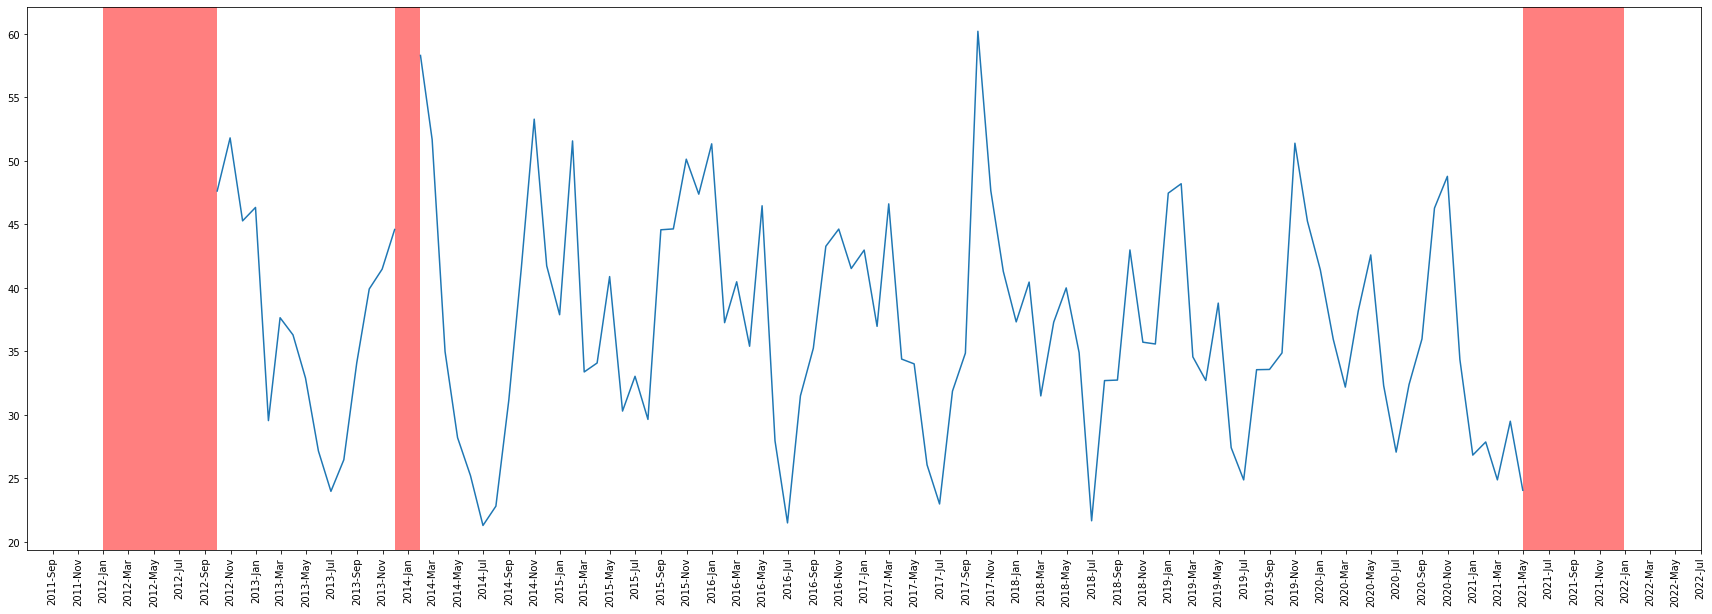

In [ ]:
df = cp_o3_8h_month

# plt.figure(figsize=(30,10))

ax = plt.gca()
# start by your date and then your data
ax.plot(df.index,df["O3"]) # daily data
# You can change the step of range() as you prefer (now, it selects each third month) 
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
# you can change the format of the label (now it is 2016-Jan)  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.setp(ax.get_xticklabels(), rotation=90) 

#code to find the start index and stop index of the groups of NaNs
#resuls in list which contains lists of each gap start and stop datetime
#code to find the start index and stop index of the group of NaNs

is_nan = df['O3'].isna()
n_groups = is_nan.ne(is_nan.shift()).cumsum()
gap_list = df[is_nan].groupby(n_groups).aggregate(
    lambda x: (
        x.index[0] + pd.DateOffset(months=-1),
        x.index[-1] + pd.DateOffset(months=+1)
    )
)['O3'].values

#results in list wich contains tuples of each gap start and stop datetime

gaps = gap_list

# plt.plot(df['O3'])

for gap in gaps: 
    ax.axvspan(gap[0], gap[1], facecolor='r', alpha=0.5)

plt.show()

####O3 - Interpolated

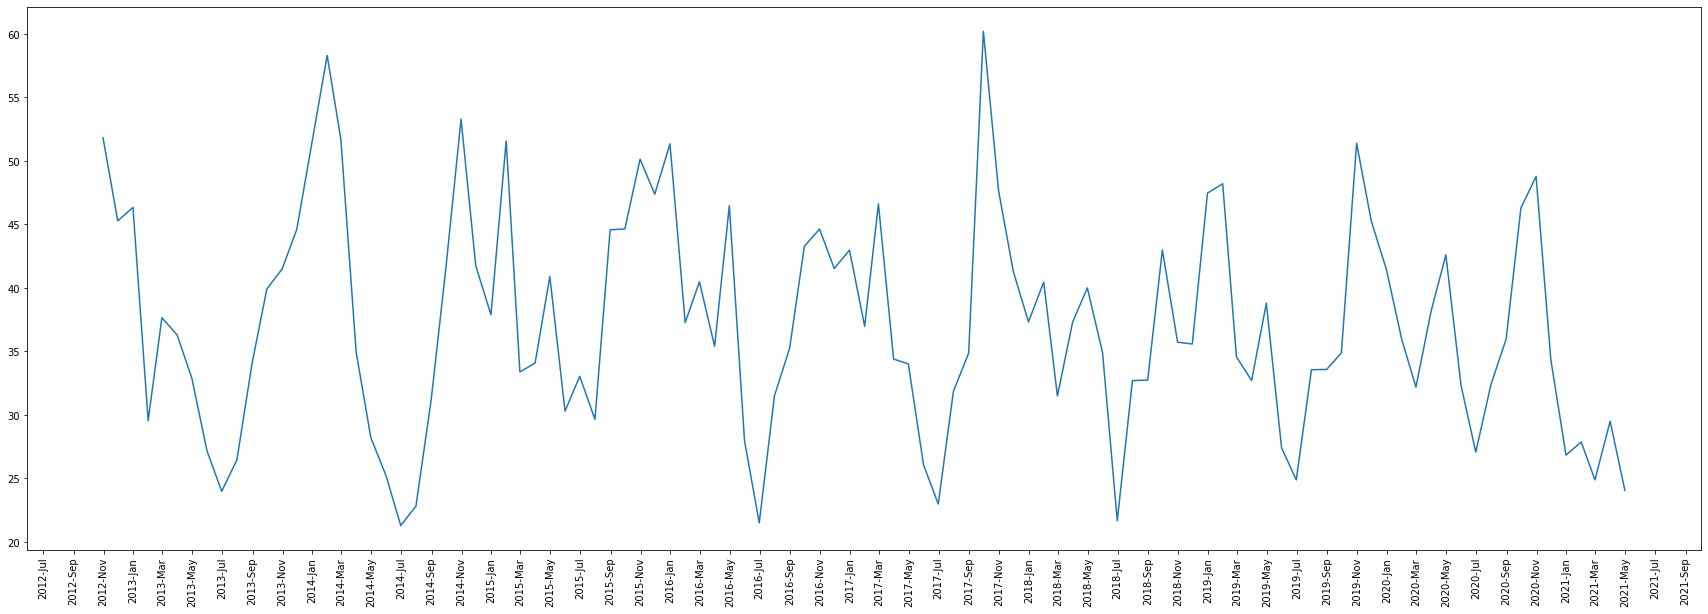

In [ ]:
df = cp_o3_8h_month['2012-10':'2021-04'].interpolate(method='time')

# plt.figure(figsize=(30,10))

ax = plt.gca()
# start by your date and then your data
ax.plot(df.index,df["O3"]) # daily data
# You can change the step of range() as you prefer (now, it selects each third month) 
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
# you can change the format of the label (now it is 2016-Jan)  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.setp(ax.get_xticklabels(), rotation=90) 

#code to find the start index and stop index of the groups of NaNs
#resuls in list which contains lists of each gap start and stop datetime
#code to find the start index and stop index of the group of NaNs

is_nan = df['O3'].isna()
n_groups = is_nan.ne(is_nan.shift()).cumsum()
gap_list = df[is_nan].groupby(n_groups).aggregate(
    lambda x: (
        x.index[0] + pd.DateOffset(months=-1),
        x.index[-1] + pd.DateOffset(months=+1)
    )
)['O3'].values

#results in list wich contains tuples of each gap start and stop datetime

gaps = gap_list

# plt.plot(df['O3'])

for gap in gaps: 
    ax.axvspan(gap[0], gap[1], facecolor='r', alpha=0.5)

plt.show()

###NO

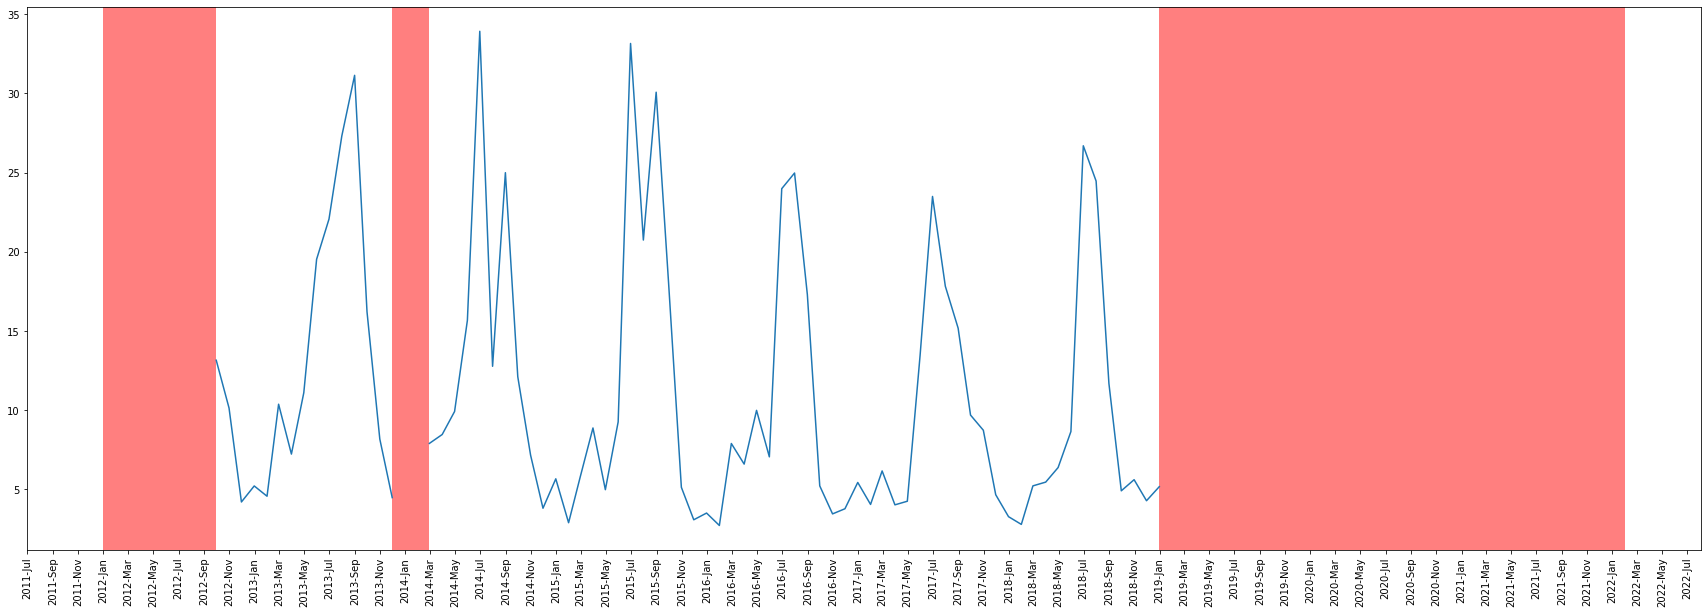

In [ ]:
df = cp_nox_month

# plt.figure(figsize=(30,10))

ax = plt.gca()
# start by your date and then your data
ax.plot(df.index,df["NO"]) # daily data
# You can change the step of range() as you prefer (now, it selects each third month) 
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
# you can change the format of the label (now it is 2016-Jan)  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.setp(ax.get_xticklabels(), rotation=90) 

#code to find the start index and stop index of the groups of NaNs
#resuls in list which contains lists of each gap start and stop datetime
#code to find the start index and stop index of the group of NaNs

is_nan = df['NO'].isna()
n_groups = is_nan.ne(is_nan.shift()).cumsum()
gap_list = df[is_nan].groupby(n_groups).aggregate(
    lambda x: (
        x.index[0] + pd.DateOffset(months=-1),
        x.index[-1] + pd.DateOffset(months=+1)
    )
)['NO'].values

#results in list wich contains tuples of each gap start and stop datetime

gaps = gap_list

# plt.plot(df['NO'])

for gap in gaps: 
    ax.axvspan(gap[0], gap[1], facecolor='r', alpha=0.5)

plt.show()

####NO - Interpolated

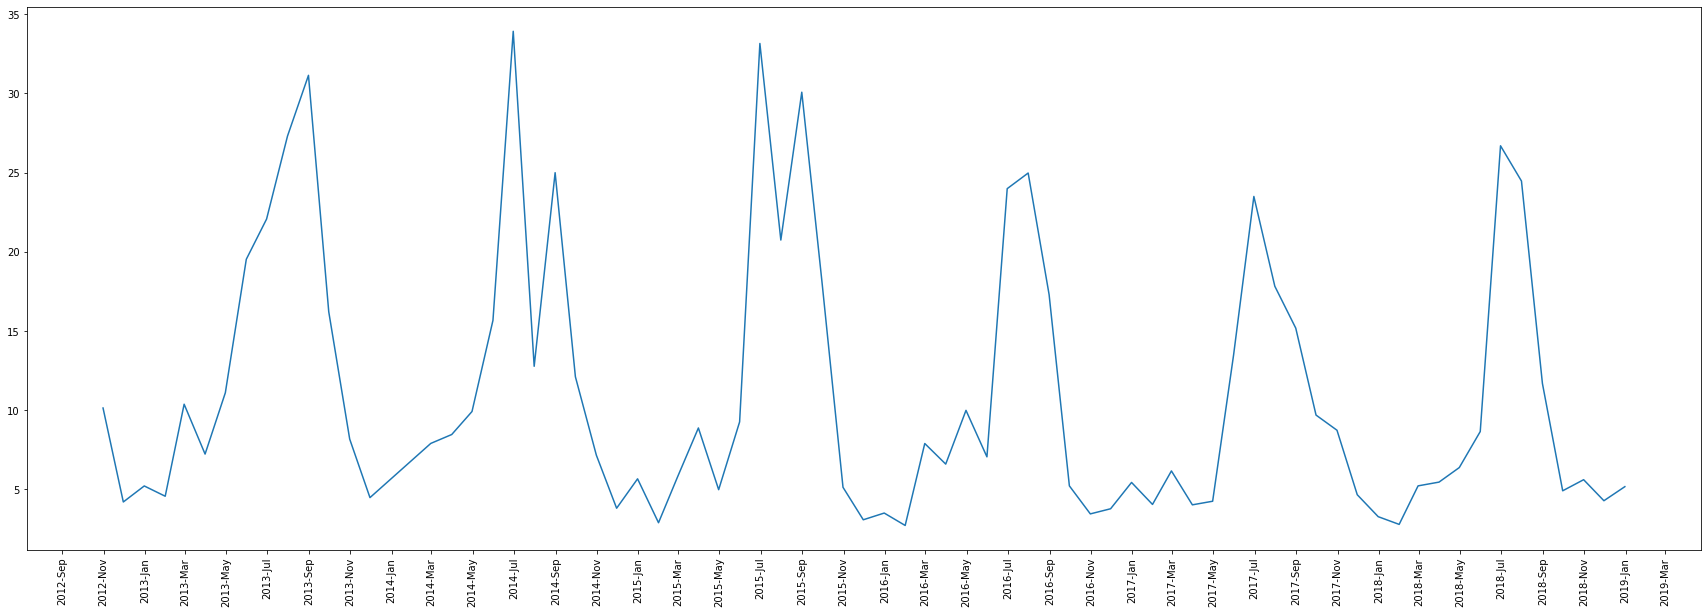

In [ ]:
df = cp_nox_month['2012-10':'2018-12'].interpolate(method='time')

# plt.figure(figsize=(30,10))

ax = plt.gca()
# start by your date and then your data
ax.plot(df.index,df["NO"]) # daily data
# You can change the step of range() as you prefer (now, it selects each third month) 
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
# you can change the format of the label (now it is 2016-Jan)  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.setp(ax.get_xticklabels(), rotation=90) 

#code to find the start index and stop index of the groups of NaNs
#resuls in list which contains lists of each gap start and stop datetime
#code to find the start index and stop index of the group of NaNs

is_nan = df['NO'].isna()
n_groups = is_nan.ne(is_nan.shift()).cumsum()
gap_list = df[is_nan].groupby(n_groups).aggregate(
    lambda x: (
        x.index[0] + pd.DateOffset(months=-1),
        x.index[-1] + pd.DateOffset(months=+1)
    )
)['NO'].values

#results in list wich contains tuples of each gap start and stop datetime

gaps = gap_list

# plt.plot(df['NO'])

for gap in gaps: 
    ax.axvspan(gap[0], gap[1], facecolor='r', alpha=0.5)

plt.show()

In [ ]:
cp_no_month = cp_nox_month['2012-10':'2018-12']['NO'].interpolate(method='time')

###NO2

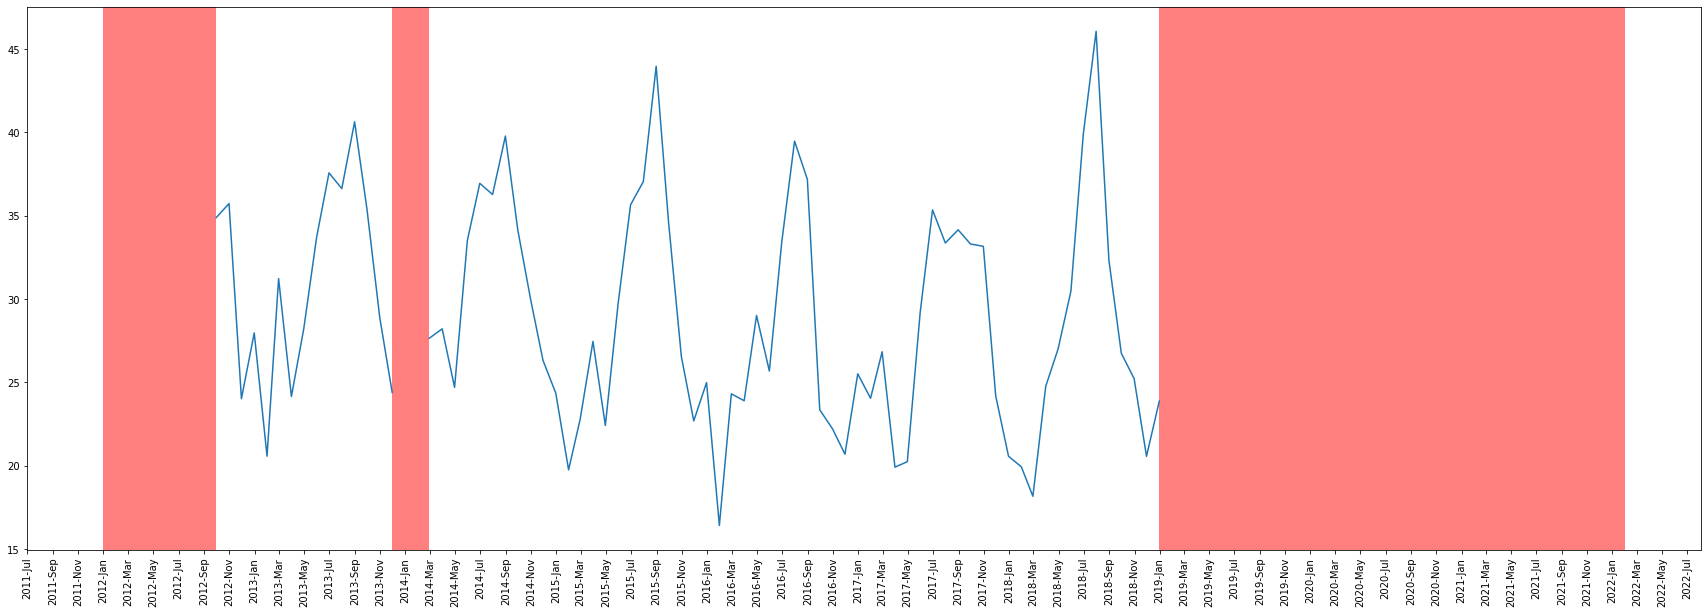

In [ ]:
df = cp_nox_month

# plt.figure(figsize=(30,10))

ax = plt.gca()
# start by your date and then your data
ax.plot(df.index,df["NO2"]) # daily data
# You can change the step of range() as you prefer (now, it selects each third month) 
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
# you can change the format of the label (now it is 2016-Jan)  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.setp(ax.get_xticklabels(), rotation=90) 

#code to find the start index and stop index of the groups of NaNs
#resuls in list which contains lists of each gap start and stop datetime
#code to find the start index and stop index of the group of NaNs

is_nan = df['NO2'].isna()
n_groups = is_nan.ne(is_nan.shift()).cumsum()
gap_list = df[is_nan].groupby(n_groups).aggregate(
    lambda x: (
        x.index[0] + pd.DateOffset(months=-1),
        x.index[-1] + pd.DateOffset(months=+1)
    )
)['NO2'].values

#results in list wich contains tuples of each gap start and stop datetime

gaps = gap_list

# plt.plot(df['NO2'])

for gap in gaps: 
    ax.axvspan(gap[0], gap[1], facecolor='r', alpha=0.5)

plt.show()

####NO2 - Interpolated

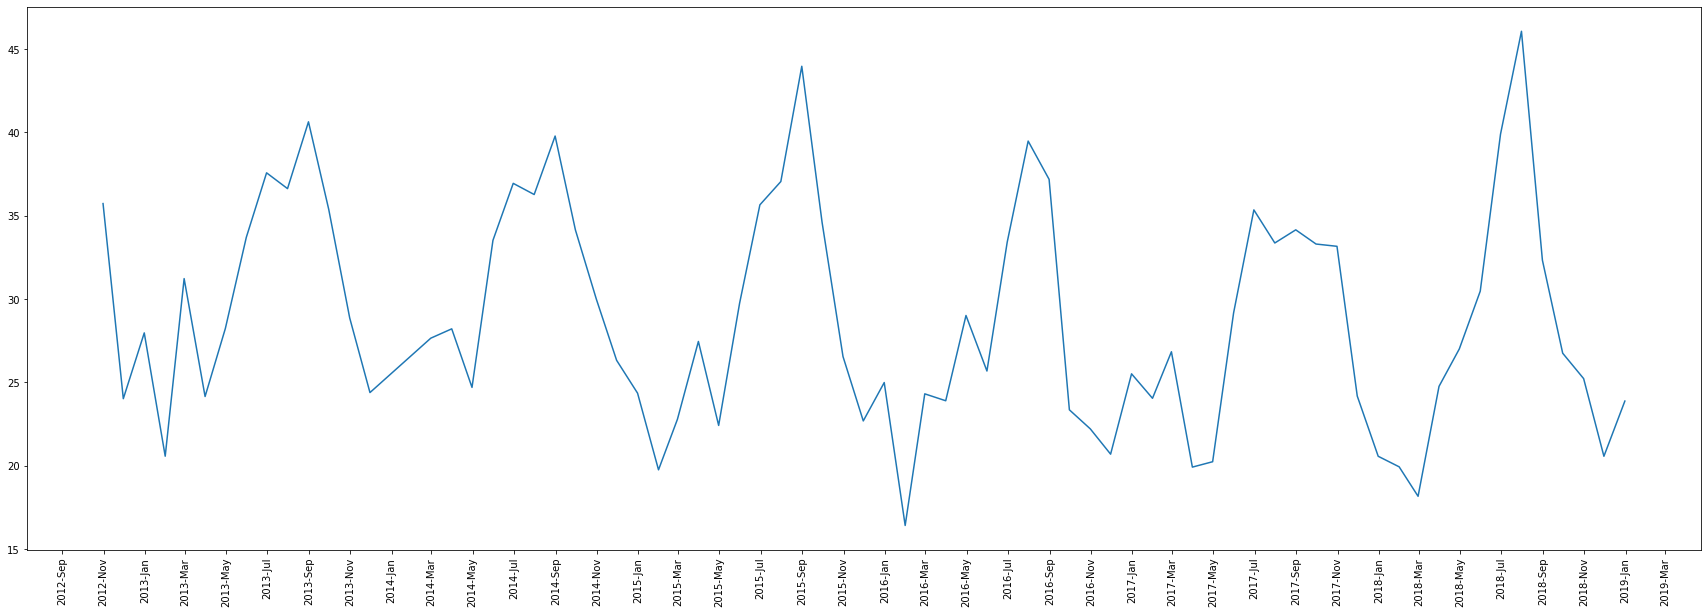

In [ ]:
df = cp_nox_month['2012-10':'2018-12'].interpolate(method='time')

# plt.figure(figsize=(30,10))

ax = plt.gca()
# start by your date and then your data
ax.plot(df.index,df["NO2"]) # daily data
# You can change the step of range() as you prefer (now, it selects each third month) 
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
# you can change the format of the label (now it is 2016-Jan)  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.setp(ax.get_xticklabels(), rotation=90) 

#code to find the start index and stop index of the groups of NaNs
#resuls in list which contains lists of each gap start and stop datetime
#code to find the start index and stop index of the group of NaNs

is_nan = df['NO2'].isna()
n_groups = is_nan.ne(is_nan.shift()).cumsum()
gap_list = df[is_nan].groupby(n_groups).aggregate(
    lambda x: (
        x.index[0] + pd.DateOffset(months=-1),
        x.index[-1] + pd.DateOffset(months=+1)
    )
)['NO2'].values

#results in list wich contains tuples of each gap start and stop datetime

gaps = gap_list

# plt.plot(df['NO2'])

for gap in gaps: 
    ax.axvspan(gap[0], gap[1], facecolor='r', alpha=0.5)

plt.show()

##Interlagos

###O3

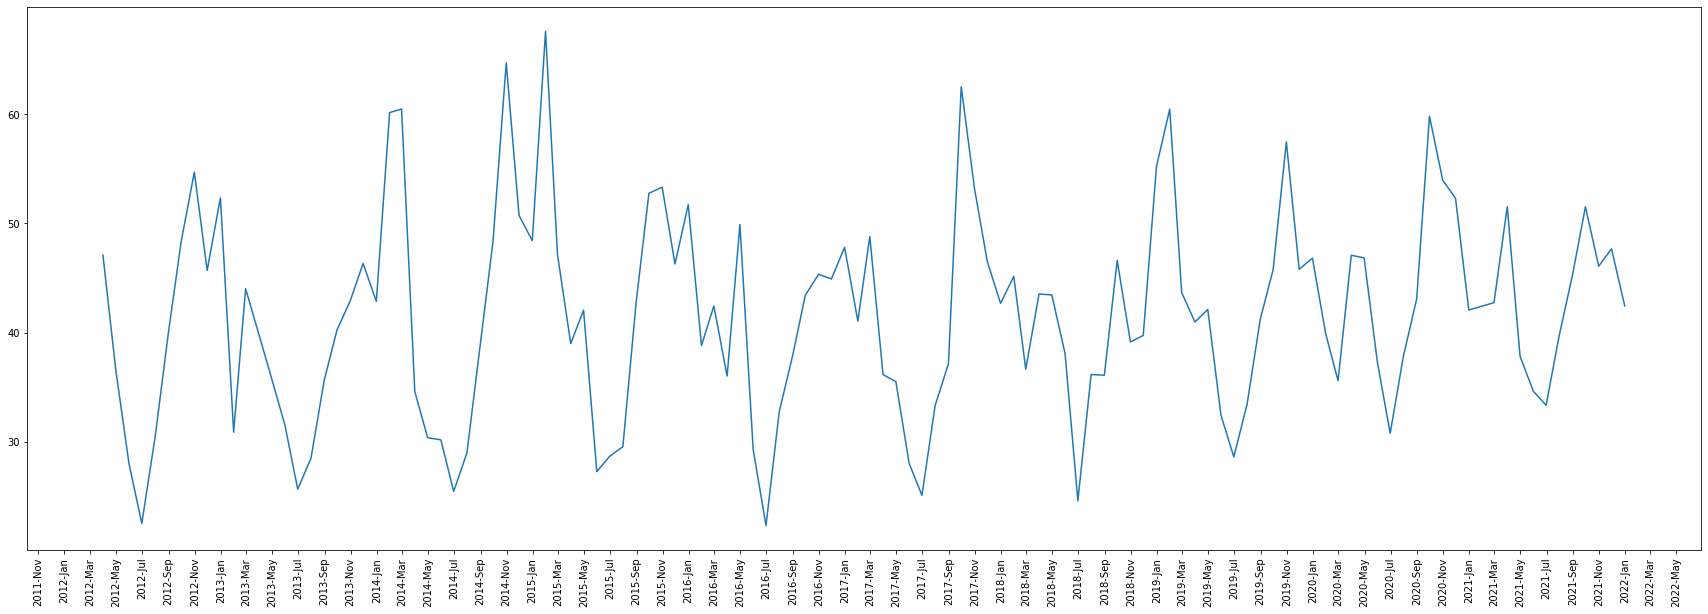

In [ ]:
df = inter_o3_8h_month

# plt.figure(figsize=(30,10))

ax = plt.gca()
# start by your date and then your data
ax.plot(df.index,df["O3"]) # daily data
# You can change the step of range() as you prefer (now, it selects each third month) 
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
# you can change the format of the label (now it is 2016-Jan)  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.setp(ax.get_xticklabels(), rotation=90) 

#code to find the start index and stop index of the groups of NaNs
#resuls in list which contains lists of each gap start and stop datetime
#code to find the start index and stop index of the group of NaNs

is_nan = df['O3'].isna()
n_groups = is_nan.ne(is_nan.shift()).cumsum()
gap_list = df[is_nan].groupby(n_groups).aggregate(
    lambda x: (
        x.index[0] + pd.DateOffset(months=-1),
        x.index[-1] + pd.DateOffset(months=+1)
    )
)['O3'].values

#results in list wich contains tuples of each gap start and stop datetime

gaps = gap_list

# plt.plot(df['O3'])

for gap in gaps: 
    ax.axvspan(gap[0], gap[1], facecolor='r', alpha=0.5)

plt.show()

####O3 - Interpolated

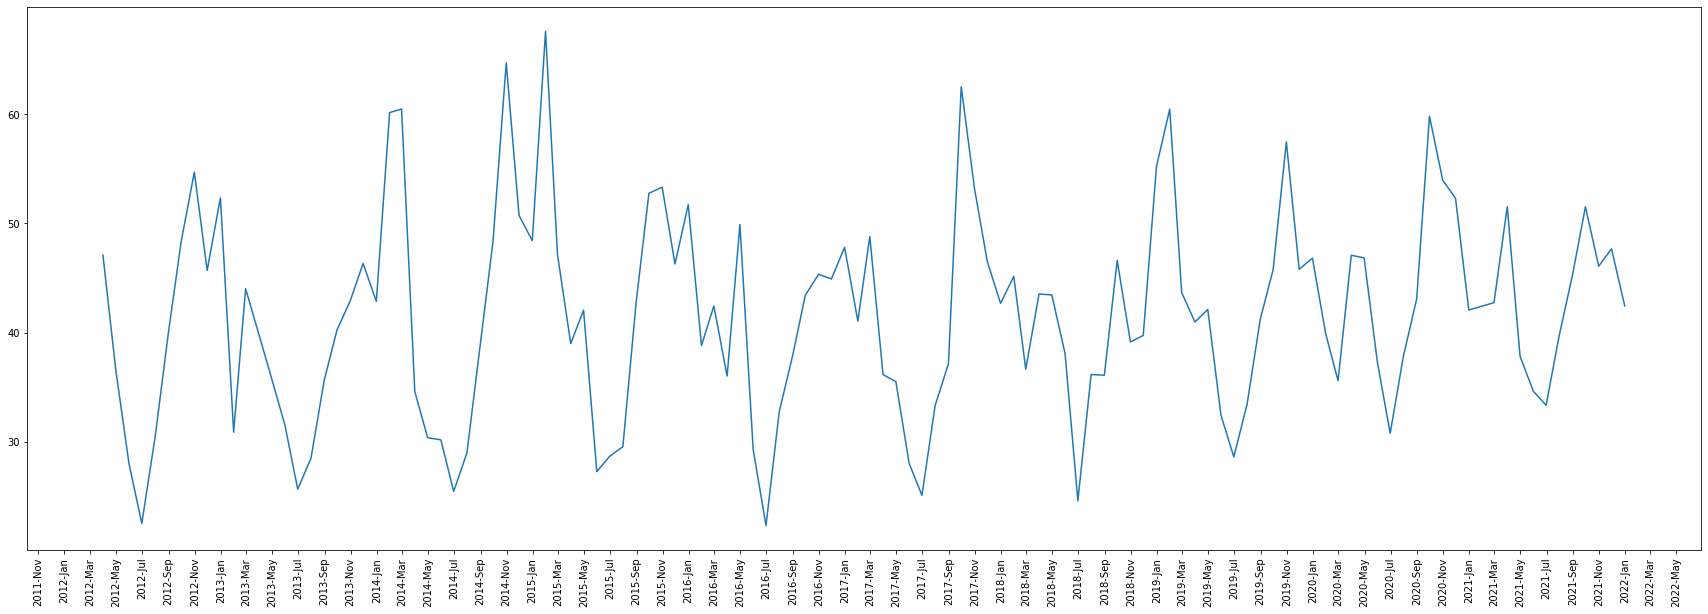

In [ ]:
df = inter_o3_8h_month['2012-03':'2021-12'].interpolate(method='time')

# plt.figure(figsize=(30,10))

ax = plt.gca()
# start by your date and then your data
ax.plot(df.index,df["O3"]) # daily data
# You can change the step of range() as you prefer (now, it selects each third month) 
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
# you can change the format of the label (now it is 2016-Jan)  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.setp(ax.get_xticklabels(), rotation=90) 

#code to find the start index and stop index of the groups of NaNs
#resuls in list which contains lists of each gap start and stop datetime
#code to find the start index and stop index of the group of NaNs

is_nan = df['O3'].isna()
n_groups = is_nan.ne(is_nan.shift()).cumsum()
gap_list = df[is_nan].groupby(n_groups).aggregate(
    lambda x: (
        x.index[0] + pd.DateOffset(months=-1),
        x.index[-1] + pd.DateOffset(months=+1)
    )
)['O3'].values

#results in list wich contains tuples of each gap start and stop datetime

gaps = gap_list

# plt.plot(df['O3'])

for gap in gaps: 
    ax.axvspan(gap[0], gap[1], facecolor='r', alpha=0.5)

plt.show()

In [ ]:
inter_o3_8h_month = inter_o3_8h_month['2012-03':'2021-12'].interpolate(method='time')

###NO

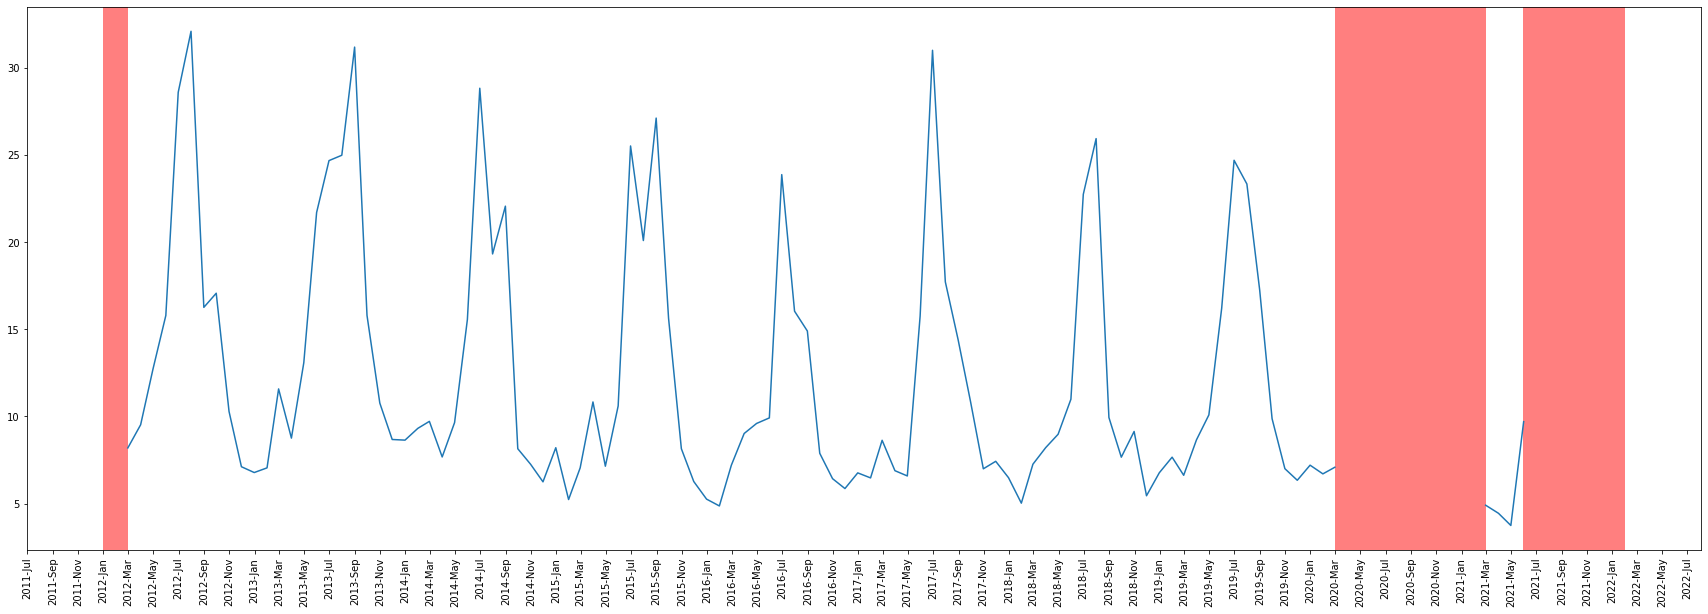

In [ ]:
df = inter_nox_month

# plt.figure(figsize=(30,10))

ax = plt.gca()
# start by your date and then your data
ax.plot(df.index,df["NO"]) # daily data
# You can change the step of range() as you prefer (now, it selects each third month) 
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
# you can change the format of the label (now it is 2016-Jan)  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.setp(ax.get_xticklabels(), rotation=90) 

#code to find the start index and stop index of the groups of NaNs
#resuls in list which contains lists of each gap start and stop datetime
#code to find the start index and stop index of the group of NaNs

is_nan = df['NO'].isna()
n_groups = is_nan.ne(is_nan.shift()).cumsum()
gap_list = df[is_nan].groupby(n_groups).aggregate(
    lambda x: (
        x.index[0] + pd.DateOffset(months=-1),
        x.index[-1] + pd.DateOffset(months=+1)
    )
)['NO'].values

#results in list wich contains tuples of each gap start and stop datetime

gaps = gap_list

# plt.plot(df['NO'])

for gap in gaps: 
    ax.axvspan(gap[0], gap[1], facecolor='r', alpha=0.5)

plt.show()

####NO - Interpolated

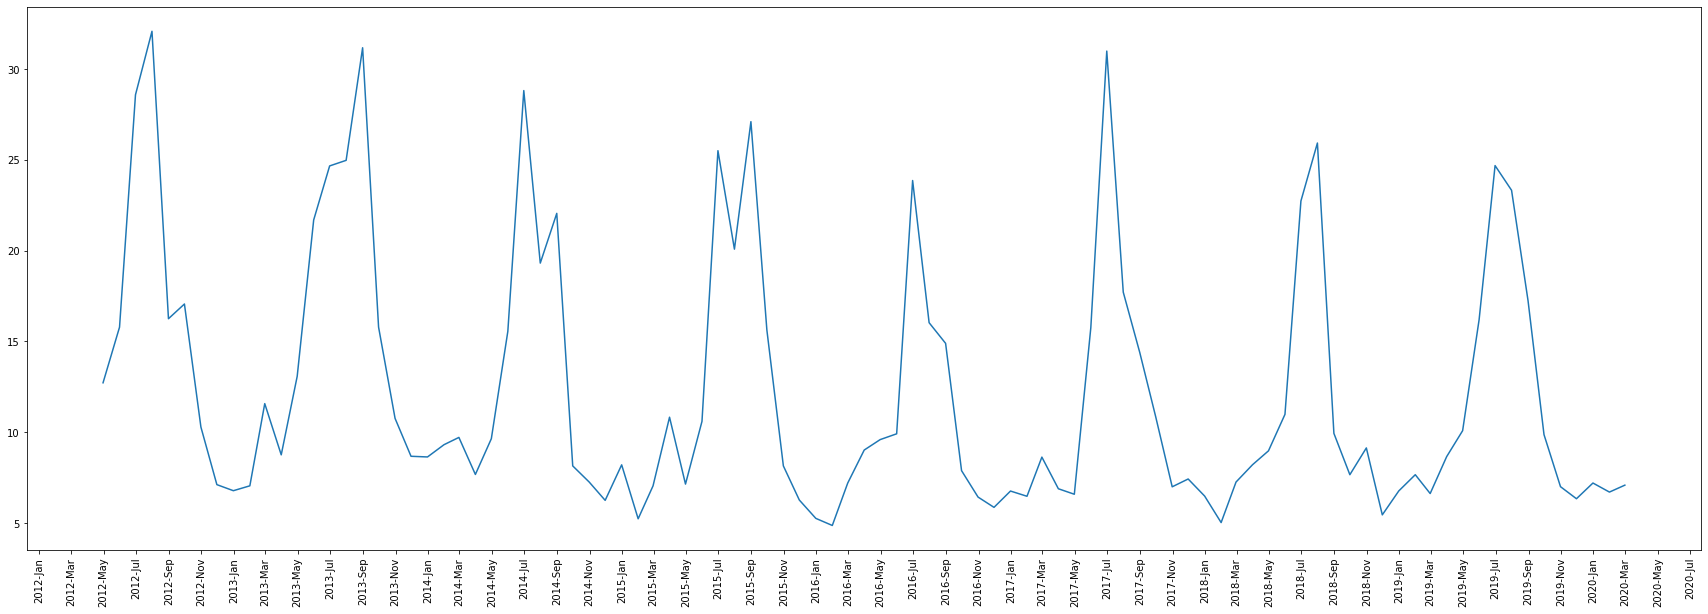

In [ ]:
df = inter_nox_month['2012-04':'2020-02'].interpolate(method='time')

# plt.figure(figsize=(30,10))

ax = plt.gca()
# start by your date and then your data
ax.plot(df.index,df["NO"]) # daily data
# You can change the step of range() as you prefer (now, it selects each third month) 
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
# you can change the format of the label (now it is 2016-Jan)  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.setp(ax.get_xticklabels(), rotation=90) 

#code to find the start index and stop index of the groups of NaNs
#resuls in list which contains lists of each gap start and stop datetime
#code to find the start index and stop index of the group of NaNs

is_nan = df['NO'].isna()
n_groups = is_nan.ne(is_nan.shift()).cumsum()
gap_list = df[is_nan].groupby(n_groups).aggregate(
    lambda x: (
        x.index[0] + pd.DateOffset(months=-1),
        x.index[-1] + pd.DateOffset(months=+1)
    )
)['NO'].values

#results in list wich contains tuples of each gap start and stop datetime

gaps = gap_list

# plt.plot(df['NO'])

for gap in gaps: 
    ax.axvspan(gap[0], gap[1], facecolor='r', alpha=0.5)

plt.show()

In [ ]:
inter_no_month = inter_nox_month['2012-04':'2020-02']['NO'].interpolate(method='time')

###NO2

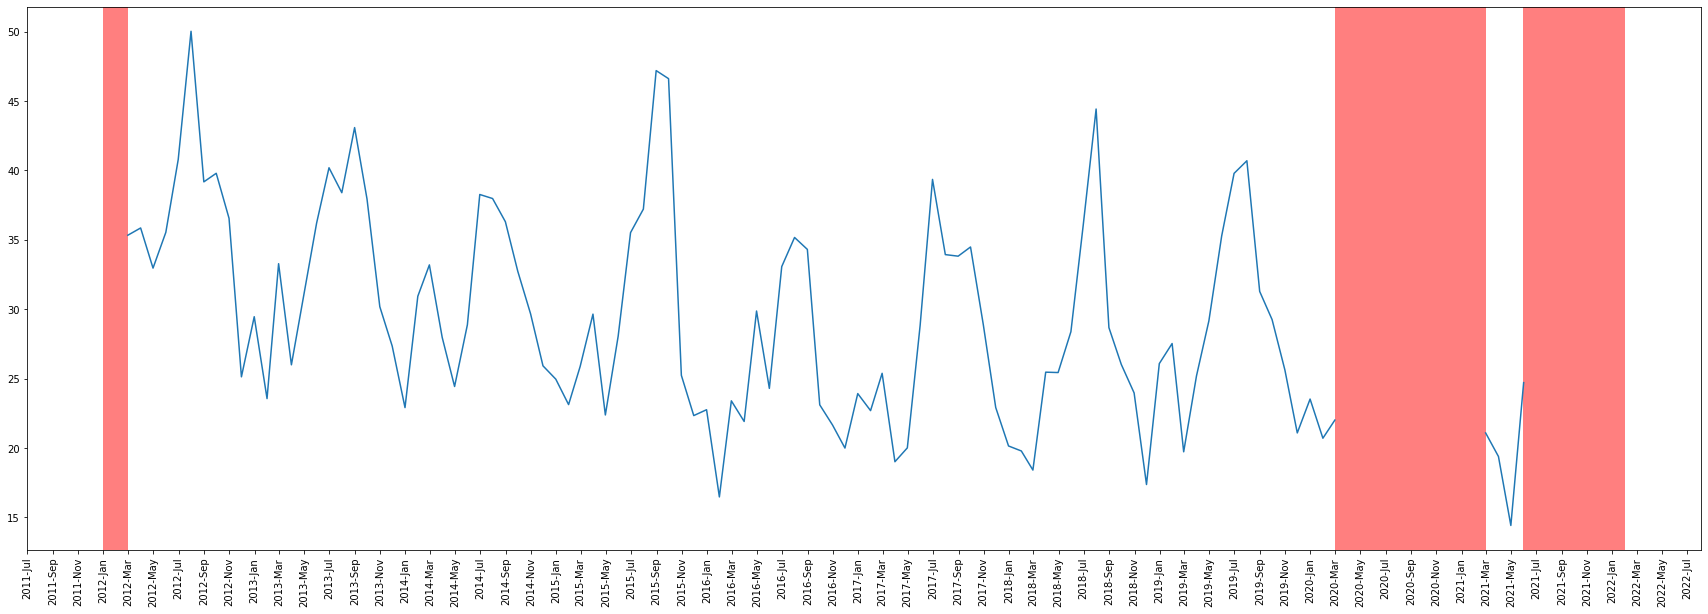

In [ ]:
df = inter_nox_month

# plt.figure(figsize=(30,10))

ax = plt.gca()
# start by your date and then your data
ax.plot(df.index,df["NO2"]) # daily data
# You can change the step of range() as you prefer (now, it selects each third month) 
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
# you can change the format of the label (now it is 2016-Jan)  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.setp(ax.get_xticklabels(), rotation=90) 

#code to find the start index and stop index of the groups of NaNs
#resuls in list which contains lists of each gap start and stop datetime
#code to find the start index and stop index of the group of NaNs

is_nan = df['NO2'].isna()
n_groups = is_nan.ne(is_nan.shift()).cumsum()
gap_list = df[is_nan].groupby(n_groups).aggregate(
    lambda x: (
        x.index[0] + pd.DateOffset(months=-1),
        x.index[-1] + pd.DateOffset(months=+1)
    )
)['NO2'].values

#results in list wich contains tuples of each gap start and stop datetime

gaps = gap_list

# plt.plot(df['NO2'])

for gap in gaps: 
    ax.axvspan(gap[0], gap[1], facecolor='r', alpha=0.5)

plt.show()

####NO2 - Interpolated

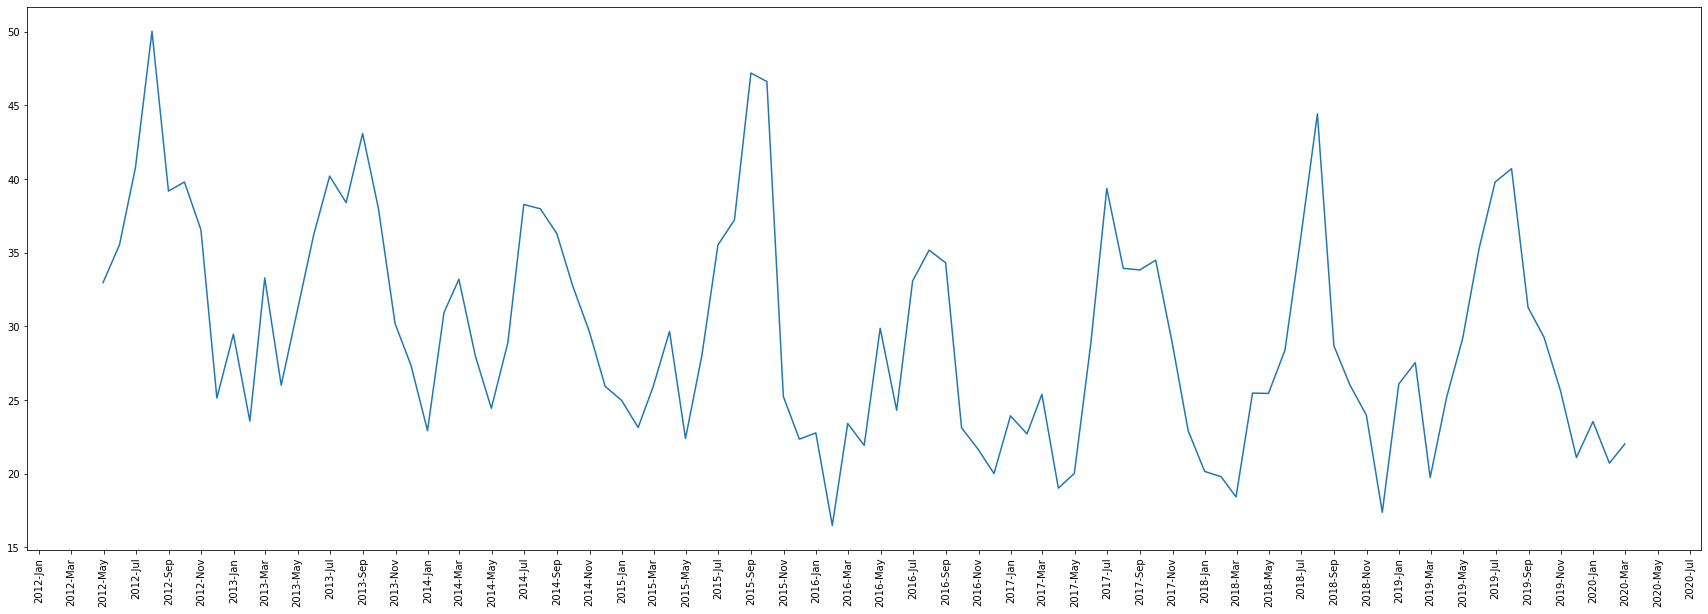

In [ ]:
df = inter_nox_month['2012-04':'2020-02'].interpolate(method='time')

# plt.figure(figsize=(30,10))

ax = plt.gca()
# start by your date and then your data
ax.plot(df.index,df["NO2"]) # daily data
# You can change the step of range() as you prefer (now, it selects each third month) 
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
# you can change the format of the label (now it is 2016-Jan)  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.setp(ax.get_xticklabels(), rotation=90) 

#code to find the start index and stop index of the groups of NaNs
#resuls in list which contains lists of each gap start and stop datetime
#code to find the start index and stop index of the group of NaNs

is_nan = df['NO2'].isna()
n_groups = is_nan.ne(is_nan.shift()).cumsum()
gap_list = df[is_nan].groupby(n_groups).aggregate(
    lambda x: (
        x.index[0] + pd.DateOffset(months=-1),
        x.index[-1] + pd.DateOffset(months=+1)
    )
)['NO2'].values

#results in list wich contains tuples of each gap start and stop datetime

gaps = gap_list

# plt.plot(df['NO2'])

for gap in gaps: 
    ax.axvspan(gap[0], gap[1], facecolor='r', alpha=0.5)

plt.show()

##Parque Dom Pedro II

###NO

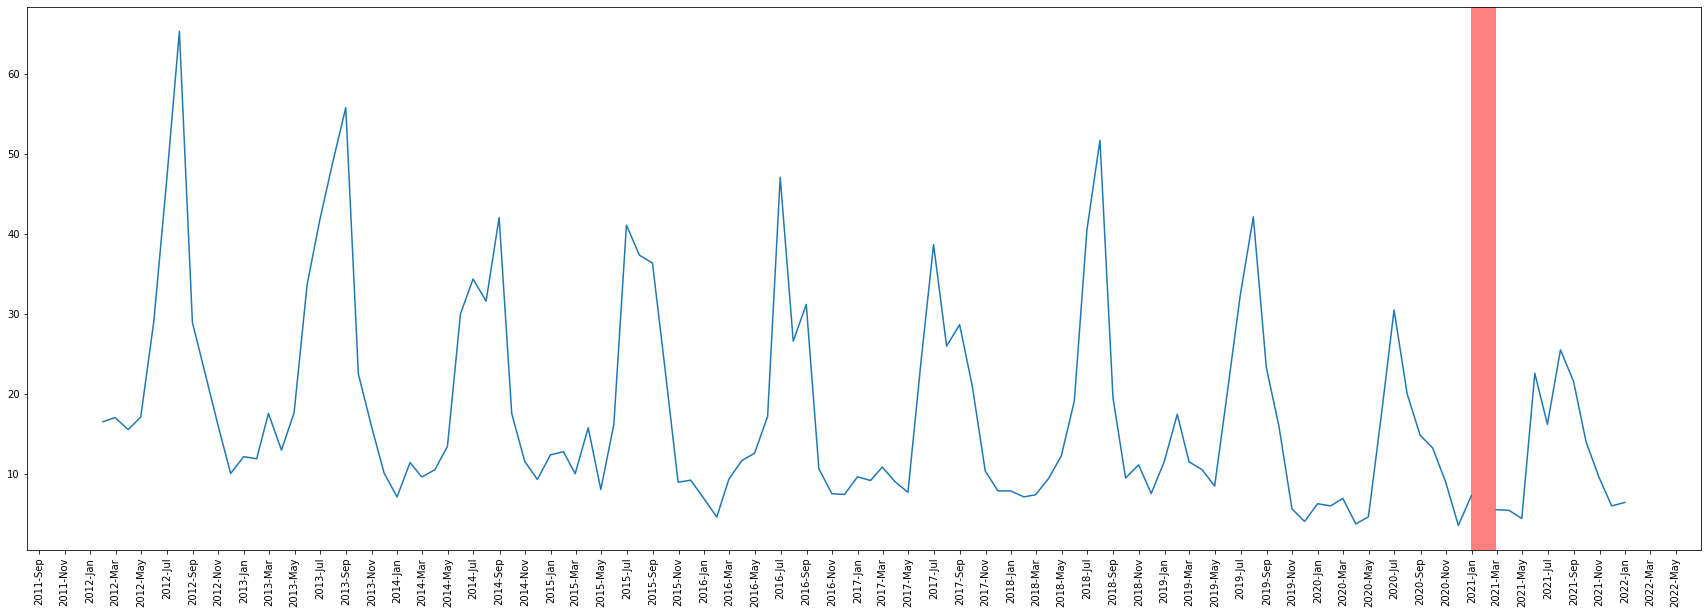

In [ ]:
df = pq_nox_month

# plt.figure(figsize=(30,10))

ax = plt.gca()
# start by your date and then your data
ax.plot(df.index,df["NO"]) # daily data
# You can change the step of range() as you prefer (now, it selects each third month) 
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
# you can change the format of the label (now it is 2016-Jan)  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.setp(ax.get_xticklabels(), rotation=90) 

#code to find the start index and stop index of the groups of NaNs
#resuls in list which contains lists of each gap start and stop datetime
#code to find the start index and stop index of the group of NaNs

is_nan = df['NO'].isna()
n_groups = is_nan.ne(is_nan.shift()).cumsum()
gap_list = df[is_nan].groupby(n_groups).aggregate(
    lambda x: (
        x.index[0] + pd.DateOffset(months=-1),
        x.index[-1] + pd.DateOffset(months=+1)
    )
)['NO'].values

#results in list wich contains tuples of each gap start and stop datetime

gaps = gap_list

# plt.plot(df['NO'])

for gap in gaps: 
    ax.axvspan(gap[0], gap[1], facecolor='r', alpha=0.5)

plt.show()

####NO - Interpolated

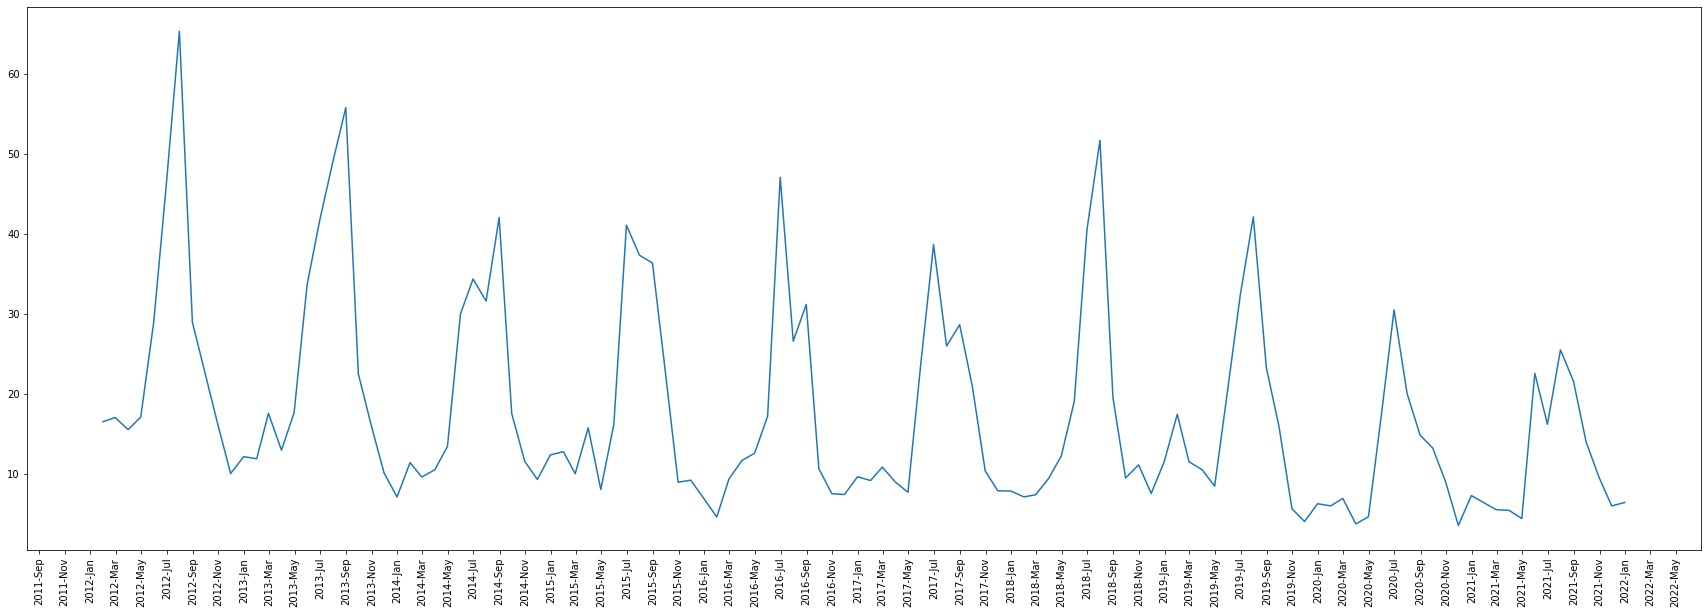

In [ ]:
df = pq_nox_month.interpolate(method='time')

# plt.figure(figsize=(30,10))

ax = plt.gca()
# start by your date and then your data
ax.plot(df.index,df["NO"]) # daily data
# You can change the step of range() as you prefer (now, it selects each third month) 
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
# you can change the format of the label (now it is 2016-Jan)  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.setp(ax.get_xticklabels(), rotation=90) 

#code to find the start index and stop index of the groups of NaNs
#resuls in list which contains lists of each gap start and stop datetime
#code to find the start index and stop index of the group of NaNs

is_nan = df['NO'].isna()
n_groups = is_nan.ne(is_nan.shift()).cumsum()
gap_list = df[is_nan].groupby(n_groups).aggregate(
    lambda x: (
        x.index[0] + pd.DateOffset(months=-1),
        x.index[-1] + pd.DateOffset(months=+1)
    )
)['NO'].values

#results in list wich contains tuples of each gap start and stop datetime

gaps = gap_list

# plt.plot(df['NO'])

for gap in gaps: 
    ax.axvspan(gap[0], gap[1], facecolor='r', alpha=0.5)

plt.show()

In [ ]:
pq_no_month = pq_nox_month['NO'].interpolate(method='time')

###NO2

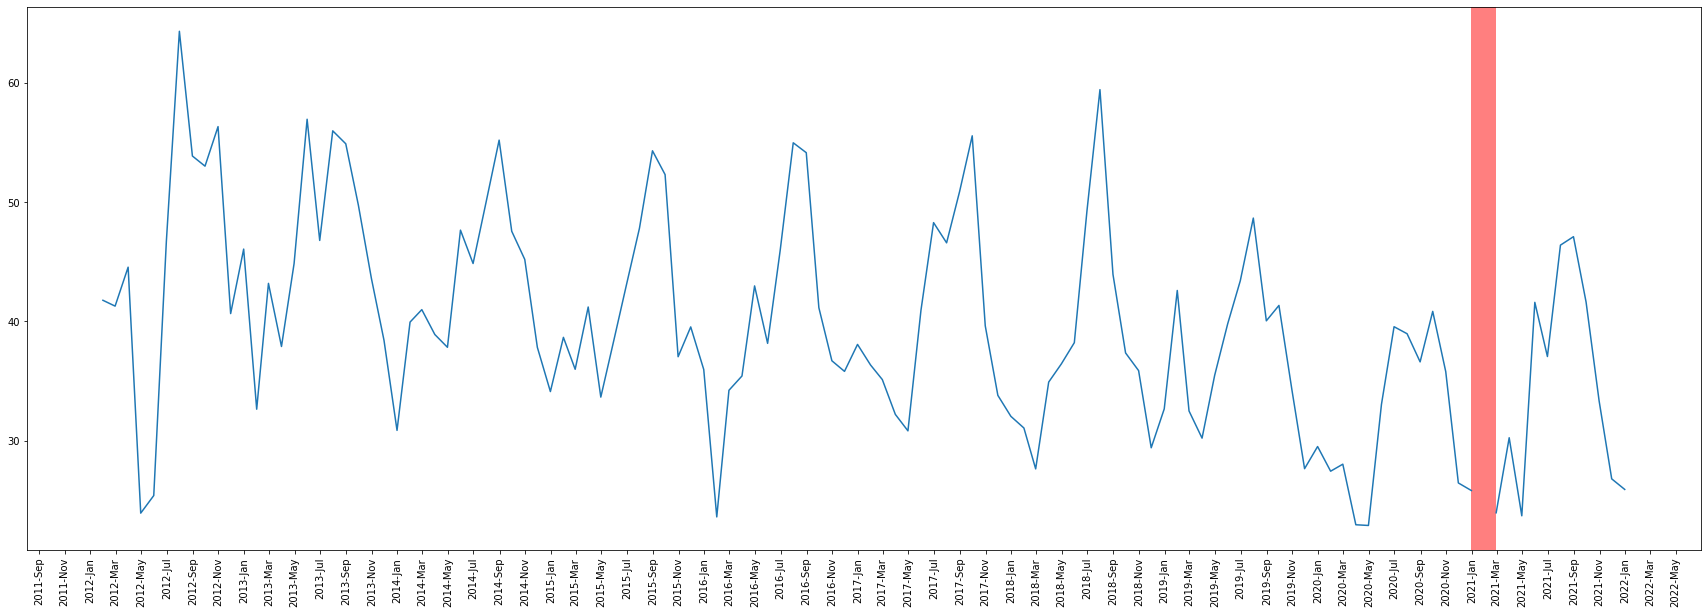

In [ ]:
df = pq_nox_month

# plt.figure(figsize=(30,10))

ax = plt.gca()
# start by your date and then your data
ax.plot(df.index,df["NO2"]) # daily data
# You can change the step of range() as you prefer (now, it selects each third month) 
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
# you can change the format of the label (now it is 2016-Jan)  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.setp(ax.get_xticklabels(), rotation=90) 

#code to find the start index and stop index of the groups of NaNs
#resuls in list which contains lists of each gap start and stop datetime
#code to find the start index and stop index of the group of NaNs

is_nan = df['NO2'].isna()
n_groups = is_nan.ne(is_nan.shift()).cumsum()
gap_list = df[is_nan].groupby(n_groups).aggregate(
    lambda x: (
        x.index[0] + pd.DateOffset(months=-1),
        x.index[-1] + pd.DateOffset(months=+1)
    )
)['NO2'].values

#results in list wich contains tuples of each gap start and stop datetime

gaps = gap_list

# plt.plot(df['NO2'])

for gap in gaps: 
    ax.axvspan(gap[0], gap[1], facecolor='r', alpha=0.5)

plt.show()

####NO2 - Interpolated

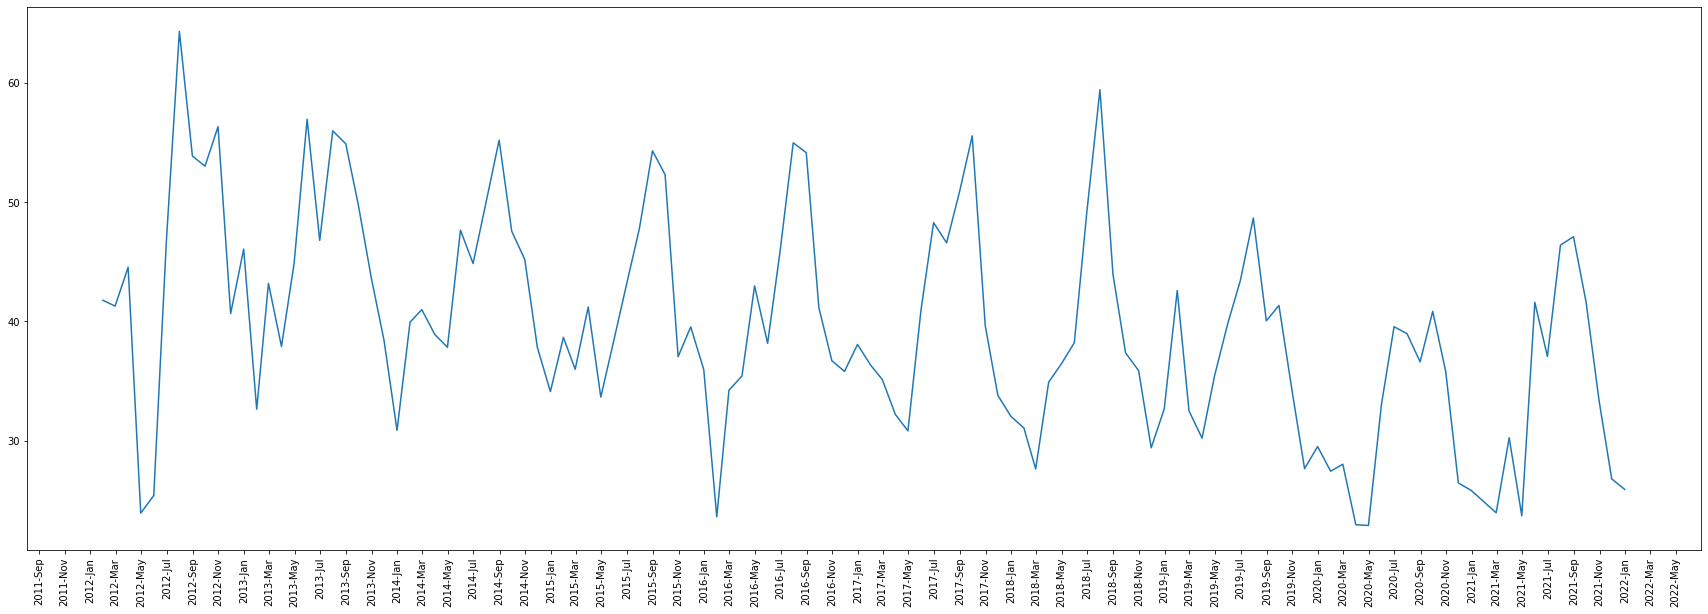

In [ ]:
df = pq_nox_month.interpolate(method='time')

# plt.figure(figsize=(30,10))

ax = plt.gca()
# start by your date and then your data
ax.plot(df.index,df["NO2"]) # daily data
# You can change the step of range() as you prefer (now, it selects each third month) 
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,2)))
# you can change the format of the label (now it is 2016-Jan)  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.setp(ax.get_xticklabels(), rotation=90) 

#code to find the start index and stop index of the groups of NaNs
#resuls in list which contains lists of each gap start and stop datetime
#code to find the start index and stop index of the group of NaNs

is_nan = df['NO2'].isna()
n_groups = is_nan.ne(is_nan.shift()).cumsum()
gap_list = df[is_nan].groupby(n_groups).aggregate(
    lambda x: (
        x.index[0] + pd.DateOffset(months=-1),
        x.index[-1] + pd.DateOffset(months=+1)
    )
)['NO2'].values

#results in list wich contains tuples of each gap start and stop datetime

gaps = gap_list

# plt.plot(df['NO2'])

for gap in gaps: 
    ax.axvspan(gap[0], gap[1], facecolor='r', alpha=0.5)

plt.show()

#Time series decomposition — ETS model

##Capão Redondo

In [ ]:
cp_o3 = seasonal_decompose(cp_o3_8h_month, model = 'multiplicative')
cp_no = seasonal_decompose(cp_no_month, model = 'multiplicative')
cp_no2 = seasonal_decompose(cp_no2_month, model = 'multiplicative')

##Ibirapuera

In [ ]:
ib_o3 = seasonal_decompose(ib_o3_8h_month, model = 'multiplicative')
ib_no = seasonal_decompose(ib_nox_month['NO'], model = 'multiplicative')
ib_no2 = seasonal_decompose(ib_nox_month['NO2'], model = 'multiplicative')

##Interlagos

In [ ]:
inter_o3 = seasonal_decompose(inter_o3_8h_month, model = 'multiplicative')
inter_no = seasonal_decompose(inter_no_month, model = 'multiplicative')
inter_no2 = seasonal_decompose(inter_no2_month, model = 'multiplicative')

##Parque Dom Pedro II

In [ ]:
pq_o3 = seasonal_decompose(pq_o3_8h_month, model = 'multiplicative')
pq_no = seasonal_decompose(pq_no_month, model = 'multiplicative')
pq_no2 = seasonal_decompose(pq_no2_month, model = 'multiplicative')

#Graphs

##Capão Redondo

###Seasonality

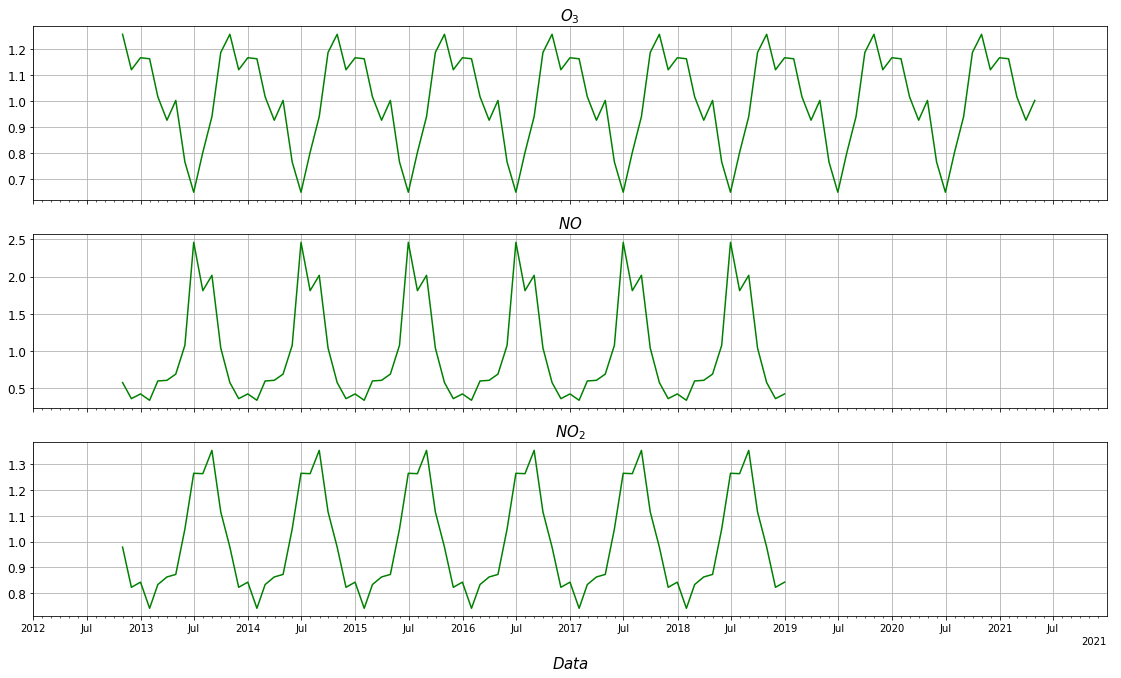

In [ ]:
y_1 = cp_o3.seasonal
y_2 = cp_no.seasonal
y_3 = cp_no2.seasonal

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, 
                                         ncols=1, 
                                         sharex=True,
                                        #  sharey=True, 
                                         figsize=(16,10)
                                        )

####

ax1.plot(y_1, label='Capão Redondo', color='green')

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(y_2, label='Ibirapuera', color='green')

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(y_3, label='Interlagos', color='green')

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')


# ax1.legend()
ax1.set_title('$O_{3}$',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax2.legend()
ax2.set_title('$NO$',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax3.legend()
ax3.set_title('$NO_{2}$',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
# plt.ylabel("$Sazonalidade\;da\;concentração\;média\;mensal\;dos\;poluentes\;(u.a.)$\n",fontsize=15)

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'cp_ets_seasonality.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

###Trend

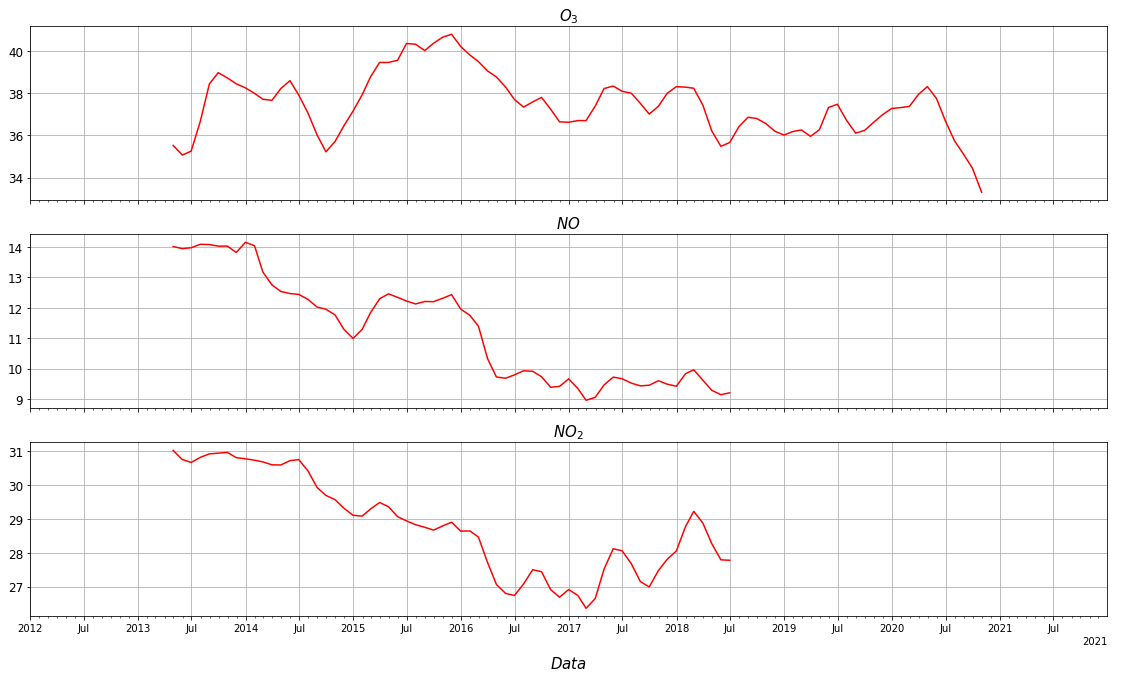

In [ ]:
y_1 = cp_o3.trend
y_2 = cp_no.trend
y_3 = cp_no2.trend

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, 
                                         ncols=1, 
                                         sharex=True,
                                        #  sharey=True, 
                                         figsize=(16,10)
                                        )

####

ax1.plot(y_1, label='Capão Redondo', color='red')

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(y_2, label='Ibirapuera', color='red')

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(y_3, label='Interlagos', color='red')

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')


# ax1.legend()
ax1.set_title('$O_{3}$',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax2.legend()
ax2.set_title('$NO$',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax3.legend()
ax3.set_title('$NO_{2}$',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
# plt.ylabel("$Sazonalidade\;da\;concentração\;média\;mensal\;dos\;poluentes\;(u.a.)$\n",fontsize=15)

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'cp_ets_trend.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

###Residual

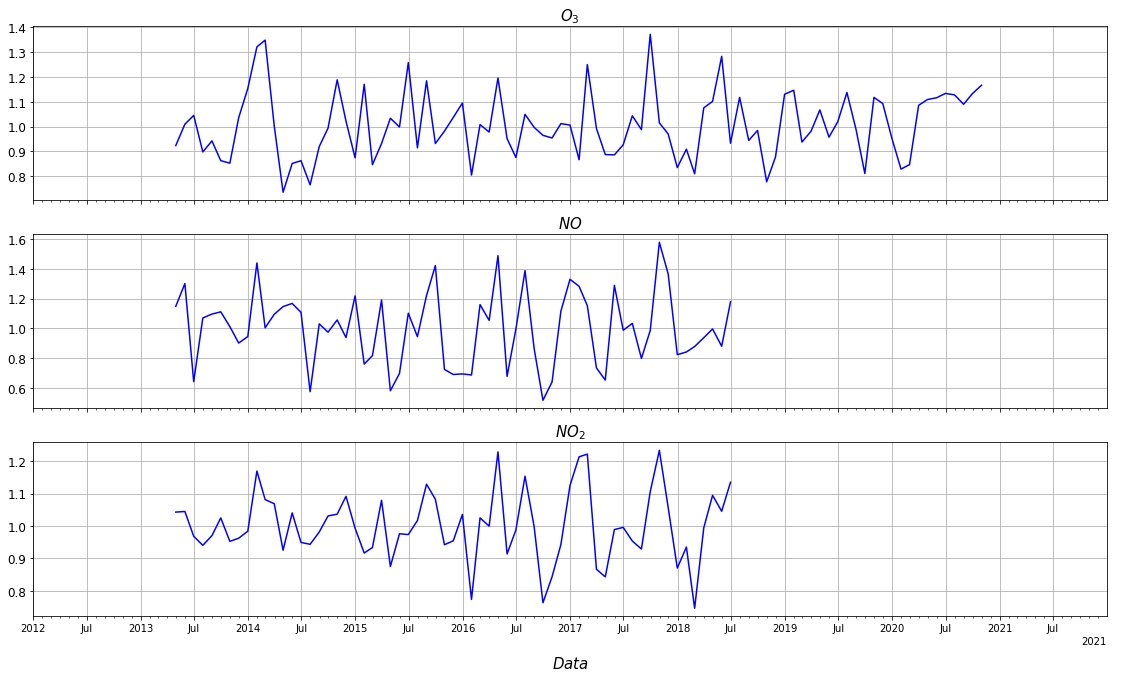

In [ ]:
y_1 = cp_o3.resid
y_2 = cp_no.resid
y_3 = cp_no2.resid

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, 
                                         ncols=1, 
                                         sharex=True,
                                        #  sharey=True, 
                                         figsize=(16,10)
                                        )

####

ax1.plot(y_1, label='Capão Redondo', color='blue')

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(y_2, label='Ibirapuera', color='blue')

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(y_3, label='Interlagos', color='blue')

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')


# ax1.legend()
ax1.set_title('$O_{3}$',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax2.legend()
ax2.set_title('$NO$',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax3.legend()
ax3.set_title('$NO_{2}$',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
# plt.ylabel("$Sazonalidade\;da\;concentração\;média\;mensal\;dos\;poluentes\;(u.a.)$\n",fontsize=15)

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'cp_ets_residual.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

##Ibirapuera

###Seasonality

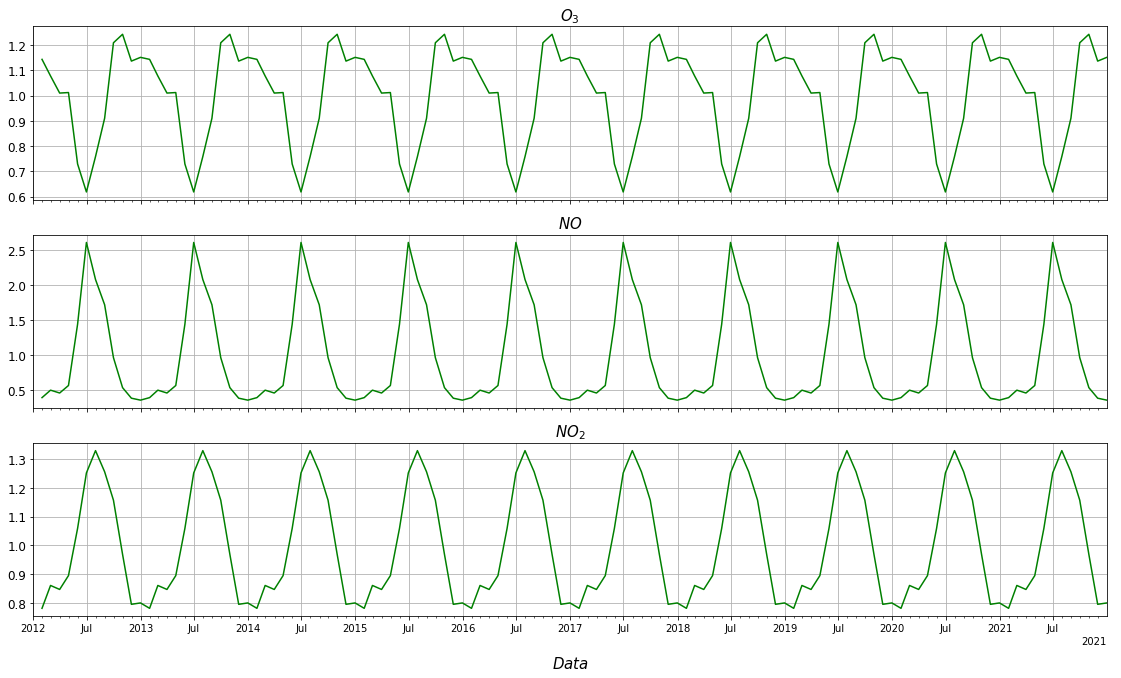

In [ ]:
y_1 = ib_o3.seasonal
y_2 = ib_no.seasonal
y_3 = ib_no2.seasonal

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, 
                                         ncols=1, 
                                         sharex=True,
                                        #  sharey=True, 
                                         figsize=(16,10)
                                        )

####

ax1.plot(y_1, label='Capão Redondo', color='green')

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(y_2, label='Ibirapuera', color='green')

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(y_3, label='Interlagos', color='green')

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')


# ax1.legend()
ax1.set_title('$O_{3}$',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax2.legend()
ax2.set_title('$NO$',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax3.legend()
ax3.set_title('$NO_{2}$',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
# plt.ylabel("$Sazonalidade\;da\;concentração\;média\;mensal\;de\;O_{3}\;(u.a.)$\n",fontsize=15)

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'ib_ets_seasonality.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

###Trend

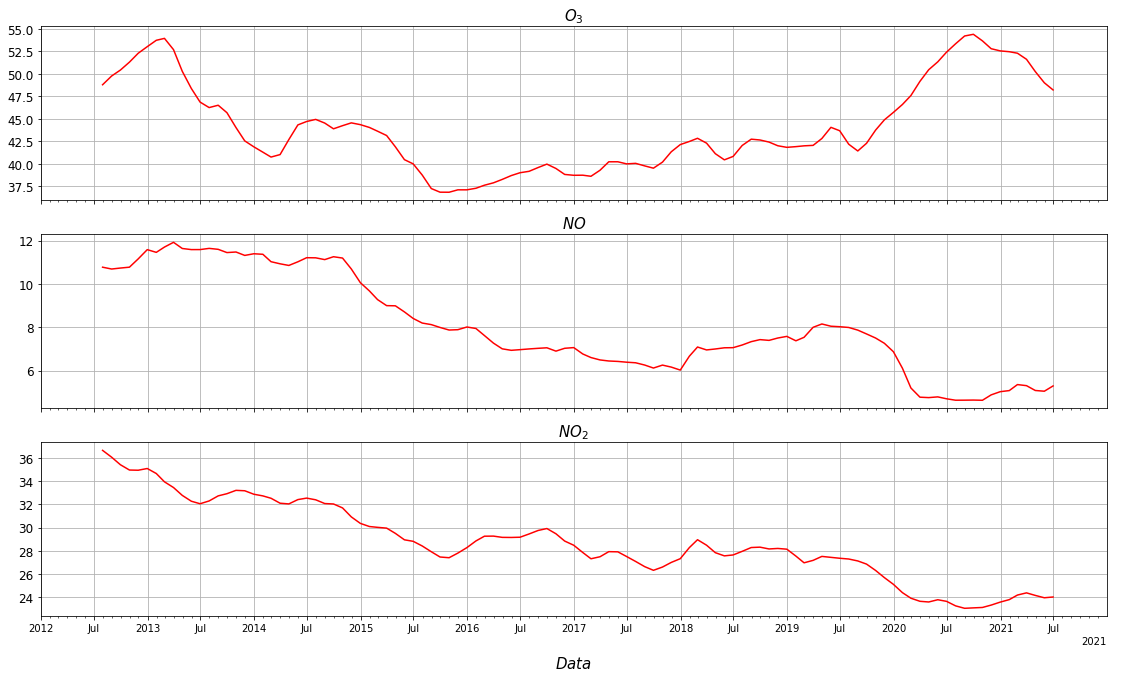

In [ ]:
y_1 = ib_o3.trend
y_2 = ib_no.trend
y_3 = ib_no2.trend

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, 
                                         ncols=1, 
                                         sharex=True,
                                        #  sharey=True, 
                                         figsize=(16,10)
                                        )

####

ax1.plot(y_1, label='Capão Redondo', color='red')

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(y_2, label='Ibirapuera', color='red')

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(y_3, label='Interlagos', color='red')

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')


# ax1.legend()
ax1.set_title('$O_{3}$',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax2.legend()
ax2.set_title('$NO$',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax3.legend()
ax3.set_title('$NO_{2}$',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
# plt.ylabel("$Sazonalidade\;da\;concentração\;média\;mensal\;de\;O_{3}\;(u.a.)$\n",fontsize=15)

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'ib_ets_trend.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

###Residual

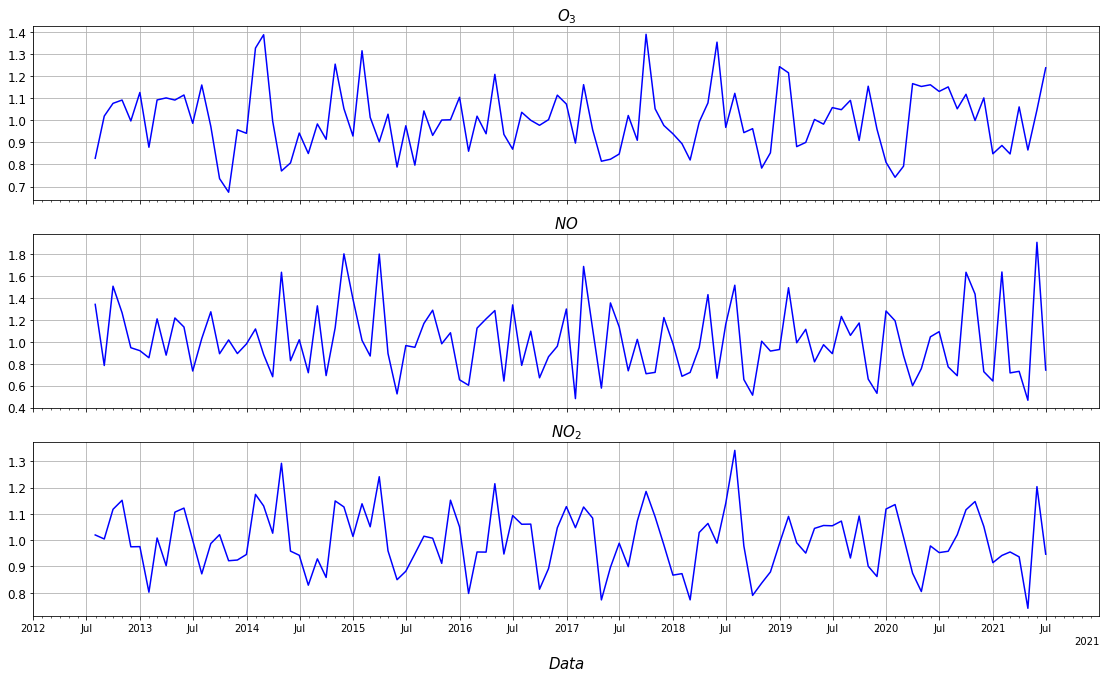

In [ ]:
y_1 = ib_o3.resid
y_2 = ib_no.resid
y_3 = ib_no2.resid

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, 
                                         ncols=1, 
                                         sharex=True,
                                        #  sharey=True, 
                                         figsize=(16,10)
                                        )

####

ax1.plot(y_1, label='Capão Redondo', color='blue')

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(y_2, label='Ibirapuera', color='blue')

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(y_3, label='Interlagos', color='blue')

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')


# ax1.legend()
ax1.set_title('$O_{3}$',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax2.legend()
ax2.set_title('$NO$',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax3.legend()
ax3.set_title('$NO_{2}$',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
# plt.ylabel("$Sazonalidade\;da\;concentração\;média\;mensal\;de\;O_{3}\;(u.a.)$\n",fontsize=15)

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'ib_ets_residual.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

##Interlagos

###Seasonality

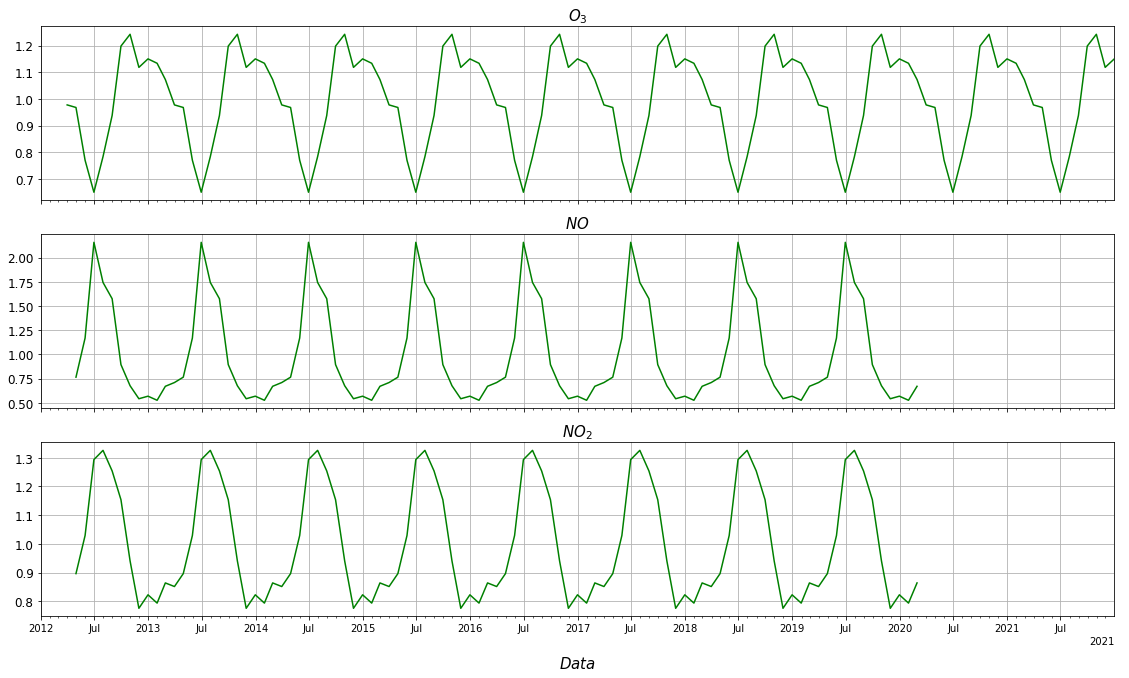

In [ ]:
y_1 = inter_o3.seasonal
y_2 = inter_no.seasonal
y_3 = inter_no2.seasonal

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, 
                                         ncols=1, 
                                         sharex=True,
                                        #  sharey=True, 
                                         figsize=(16,10)
                                        )

####

ax1.plot(y_1, label='Capão Redondo', color='green')

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(y_2, label='Ibirapuera', color='green')

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(y_3, label='Interlagos', color='green')

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')


# ax1.legend()
ax1.set_title('$O_{3}$',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax2.legend()
ax2.set_title('$NO$',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax3.legend()
ax3.set_title('$NO_{2}$',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
# plt.ylabel("$Sazonalidade\;da\;concentração\;média\;mensal\;de\;O_{3}\;(u.a.)$\n",fontsize=15)

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'inter_ets_seasonality.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

###Trend

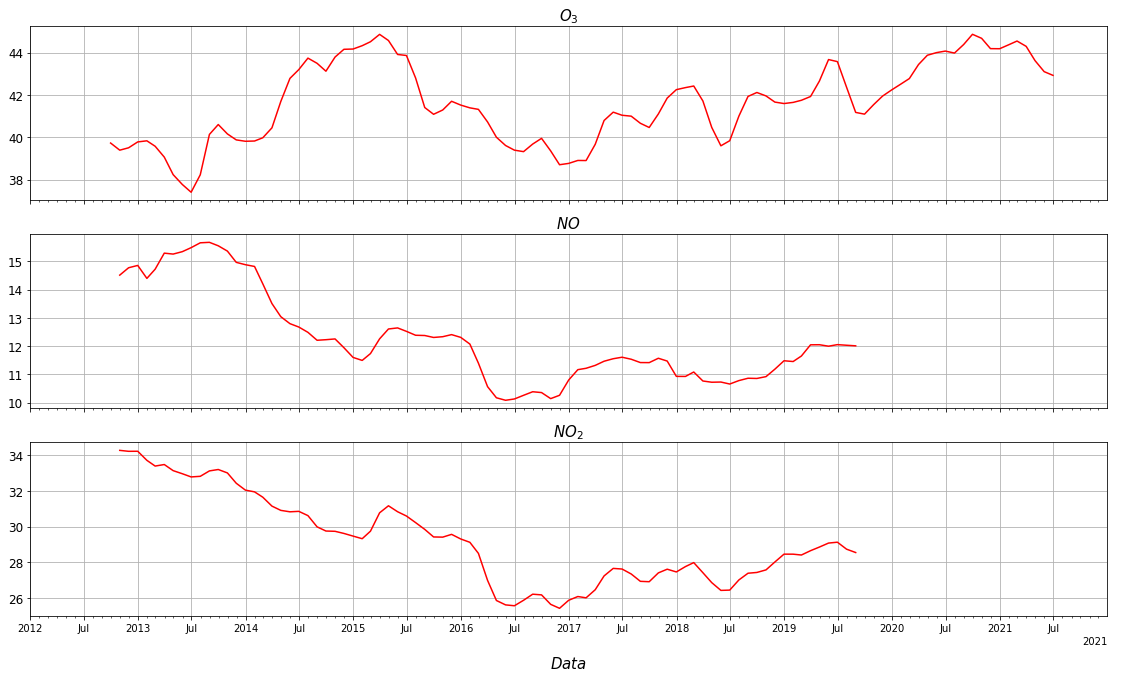

In [ ]:
y_1 = inter_o3.trend
y_2 = inter_no.trend
y_3 = inter_no2.trend

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, 
                                         ncols=1, 
                                         sharex=True,
                                        #  sharey=True, 
                                         figsize=(16,10)
                                        )

####

ax1.plot(y_1, label='Capão Redondo', color='red')

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(y_2, label='Ibirapuera', color='red')

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(y_3, label='Interlagos', color='red')

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')


# ax1.legend()
ax1.set_title('$O_{3}$',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax2.legend()
ax2.set_title('$NO$',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax3.legend()
ax3.set_title('$NO_{2}$',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
# plt.ylabel("$Sazonalidade\;da\;concentração\;média\;mensal\;de\;O_{3}\;(u.a.)$\n",fontsize=15)

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'ib_ets_trend.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

###Residual

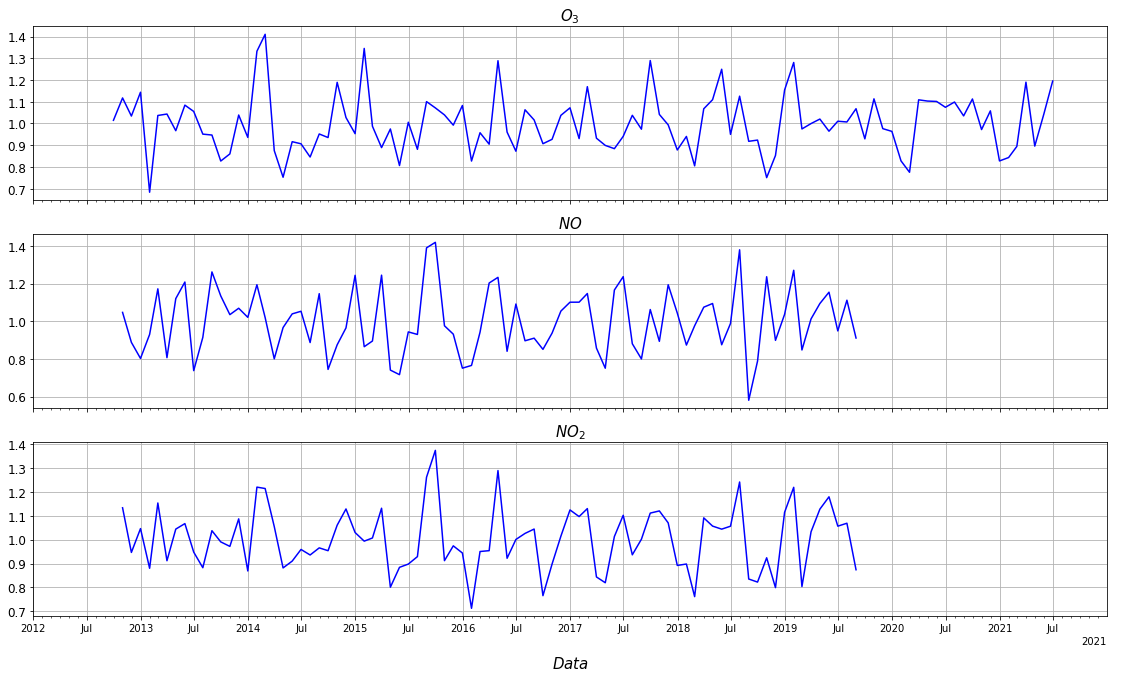

In [ ]:
y_1 = inter_o3.resid
y_2 = inter_no.resid
y_3 = inter_no2.resid

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, 
                                         ncols=1, 
                                         sharex=True,
                                        #  sharey=True, 
                                         figsize=(16,10)
                                        )

####

ax1.plot(y_1, label='Capão Redondo', color='blue')

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(y_2, label='Ibirapuera', color='blue')

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(y_3, label='Interlagos', color='blue')

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')


# ax1.legend()
ax1.set_title('$O_{3}$',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax2.legend()
ax2.set_title('$NO$',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax3.legend()
ax3.set_title('$NO_{2}$',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
# plt.ylabel("$Sazonalidade\;da\;concentração\;média\;mensal\;de\;O_{3}\;(u.a.)$\n",fontsize=15)

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'ib_ets_residual.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

##Parque dom Pedro II

###Seasonality

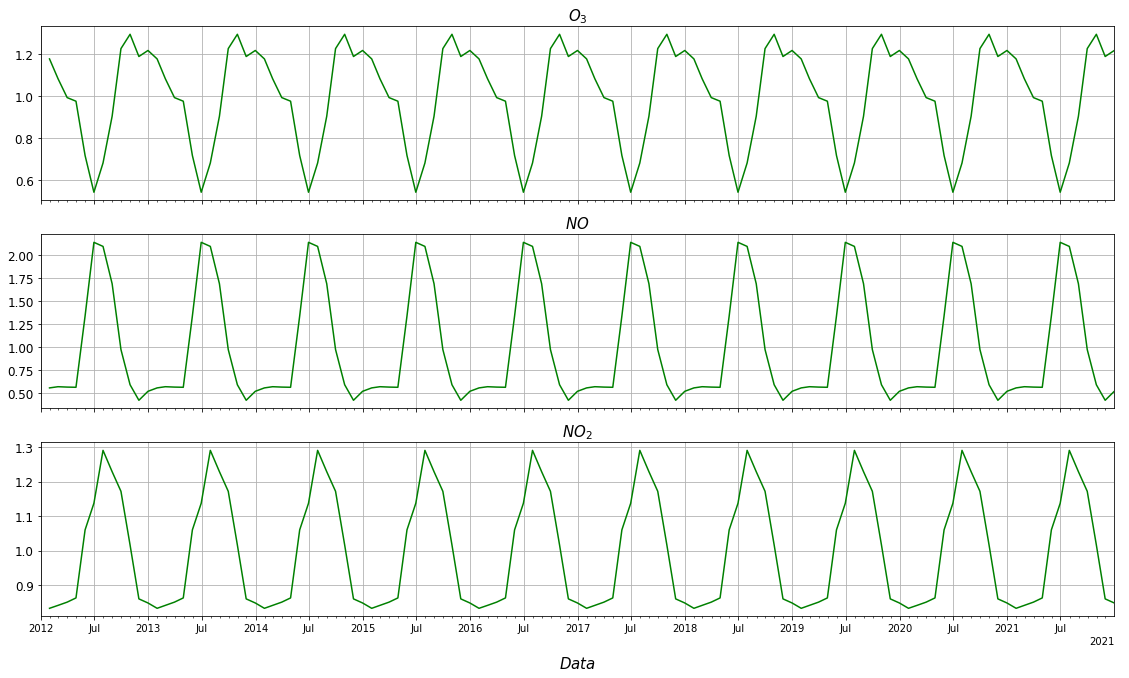

In [ ]:
y_1 = pq_o3.seasonal
y_2 = pq_no.seasonal
y_3 = pq_no2.seasonal

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, 
                                         ncols=1, 
                                         sharex=True,
                                        #  sharey=True, 
                                         figsize=(16,10)
                                        )

####

ax1.plot(y_1, label='Capão Redondo', color='green')

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(y_2, label='Ibirapuera', color='green')

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(y_3, label='Interlagos', color='green')

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')


# ax1.legend()
ax1.set_title('$O_{3}$',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax2.legend()
ax2.set_title('$NO$',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax3.legend()
ax3.set_title('$NO_{2}$',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
# plt.ylabel("$Sazonalidade\;da\;concentração\;média\;mensal\;de\;O_{3}\;(u.a.)$\n",fontsize=15)

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'pq_ets_seasonality.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

###Trend

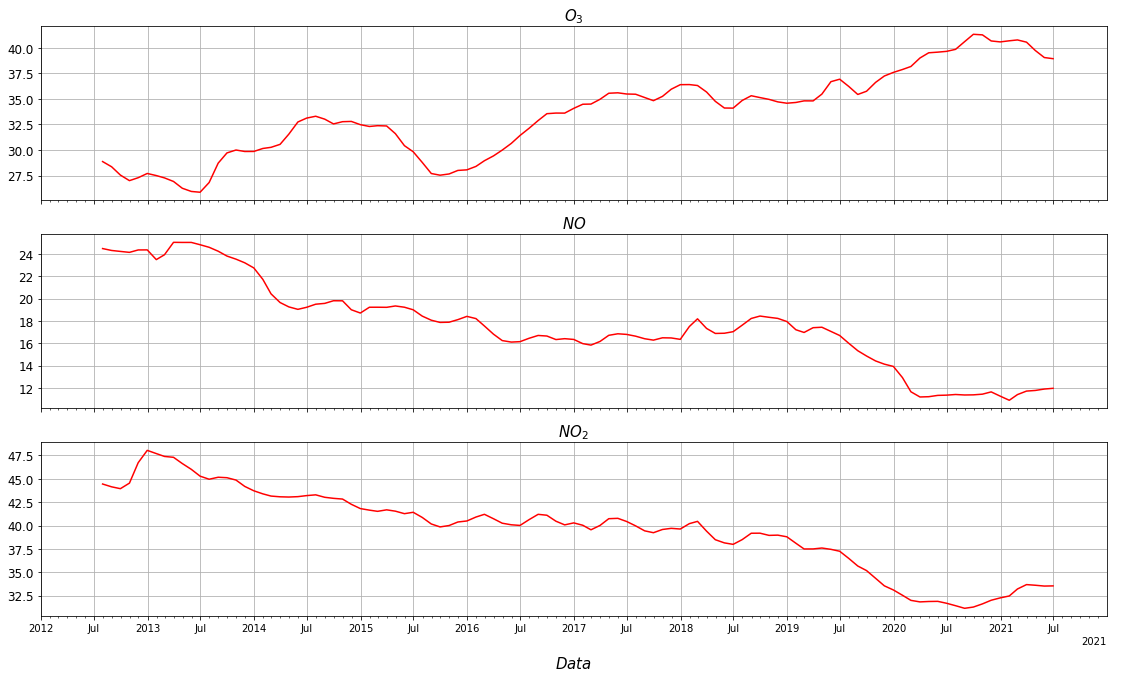

In [ ]:
y_1 = pq_o3.trend
y_2 = pq_no.trend
y_3 = pq_no2.trend

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, 
                                         ncols=1, 
                                         sharex=True,
                                        #  sharey=True, 
                                         figsize=(16,10)
                                        )

####

ax1.plot(y_1, label='Capão Redondo', color='red')

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(y_2, label='Ibirapuera', color='red')

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(y_3, label='Interlagos', color='red')

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')


# ax1.legend()
ax1.set_title('$O_{3}$',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax2.legend()
ax2.set_title('$NO$',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax3.legend()
ax3.set_title('$NO_{2}$',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
# plt.ylabel("$Sazonalidade\;da\;concentração\;média\;mensal\;de\;O_{3}\;(u.a.)$\n",fontsize=15)

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'pq_ets_trend.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()

###Residual

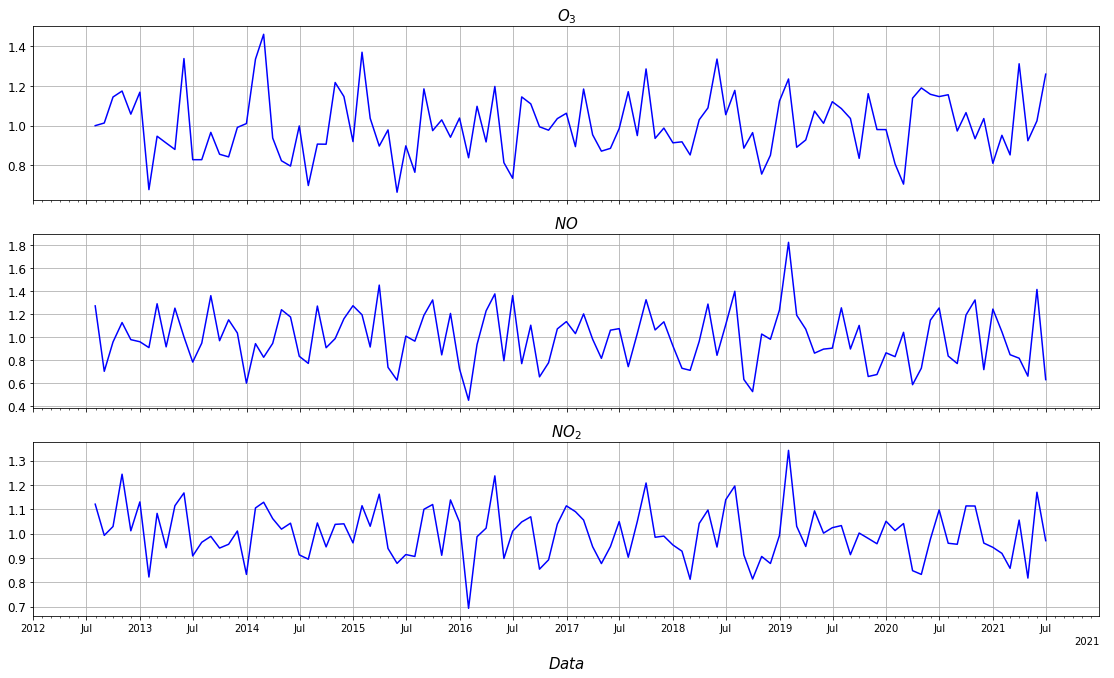

In [ ]:
y_1 = pq_o3.resid
y_2 = pq_no.resid
y_3 = pq_no2.resid

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, 
                                         ncols=1, 
                                         sharex=True,
                                        #  sharey=True, 
                                         figsize=(16,10)
                                        )

####

ax1.plot(y_1, label='Capão Redondo', color='blue')

# Major ticks every half year, minor ticks every month

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax1.xaxis.set_minor_locator(dates.MonthLocator())

ax1.grid(True)

ax1.set_ylabel(r'')

ax1.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

# Rotates and right-aligns the x labels so they don't crowd each other.

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax2.plot(y_2, label='Ibirapuera', color='blue')

ax2.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax2.xaxis.set_minor_locator(dates.MonthLocator())

ax2.grid(True)

ax2.set_ylabel(r'')

ax2.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')

####

ax3.plot(y_3, label='Interlagos', color='blue')

ax3.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))

ax3.xaxis.set_minor_locator(dates.MonthLocator())

ax3.grid(True)

ax3.set_ylabel(r'')

ax3.xaxis.set_major_formatter(
    dates.ConciseDateFormatter(ax.xaxis.get_major_locator())) 

for label in ax.get_xticklabels(which='major'):

    label.set(rotation=30, horizontalalignment='right')


# ax1.legend()
ax1.set_title('$O_{3}$',fontsize=15)
ax1.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax2.legend()
ax2.set_title('$NO$',fontsize=15)
ax2.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

# ax3.legend()
ax3.set_title('$NO_{2}$',fontsize=15)
ax3.set_xlim([dt.datetime(2012,1,1),dt.datetime(2021,12,31)], auto=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', 
                which='both', 
                top=False, 
                bottom=False, 
                left=False, 
                right=False)

plt.xlabel("\n$Data$",fontsize=15)
# plt.ylabel("$Sazonalidade\;da\;concentração\;média\;mensal\;de\;O_{3}\;(u.a.)$\n",fontsize=15)

plt.setp([ax1.get_yticklabels(),
          ax2.get_yticklabels(),
          ax3.get_yticklabels()], 
         fontsize=12
         )


plt.tight_layout()

plt.savefig(
              dir + 'pq_ets_residual.jpg',
              transparent = True,
              bbox_inches = 'tight',
              dpi = 500              
            )

plt.show()